In [1]:
!ls ../experiments/logs

ar_128		      attn_test3	  lr_sweep_llama       pcfg_easy_8192
ar_32		      attn_test_ar_32	  misc		       pcfg_easy_nope
ar_32_based_ablation  attn_test_ar_32_wd  new_lr_sweep	       pcfg_medium
ar_32_nope	      difficulty	  new_lr_sweep_gpt2    pcfg_medium_8192
arch_easy	      hyena_start	  new_lr_sweep_llama   pcfg_medium_nope
arch_evals	      lr_sweep		  new_lr_sweep_nodrop
arch_sweep	      lr_sweep_gpt2	  pcfg_easy


In [2]:
import glob
import os
import pandas as pd
import plotnine as p9
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, AutoMinorLocator
import mpltern

In [3]:
p9.theme_set(
    p9.theme_gray() +
    p9.theme(
        axis_text_x=p9.element_text(rotation=90),
        text=p9.element_text(family="P052"),
        # strip_text=p9.element_text(size=8)
    )
)

In [4]:
arch_names = {
    "attention": "Attention",
    "based": "Based",
    "base_conv": "BaseConv",
    "h3": "H3",
    "hyena": "Hyena",
    "mamba": "Mamba",
}

In [5]:
def read_df(dirs, filter_steps=5000):
    all_files = []
    for d in dirs:
        all_files.extend(list(glob.glob(d)))
    dfs = []
    for file in tqdm(all_files):
        evaluator = file.split("/")[-1].split(".")[0]
        arch, dim, lr = os.path.dirname(file).split("/")[-2].split(".")[0].split("___")
        log = pd.read_csv(file)
        log = log[(log["step"] % filter_steps) == 0]
        log["identifier"] = file
        log["arch"] = arch_names.get(arch, arch)
        log["dim"] = int(dim)
        log["lr"] = float(lr)
        log["evaluator"] = evaluator
        log["step_rel"] = log["step"] / log["step"].max()
        log["layers"] = 2
        log["dataset"] = os.path.dirname(file).split("/")[-3]
        log = log.groupby(["variable", "step", "evaluator", "step_rel", "identifier", "arch", "dim", "lr", "layers", "dataset"]).mean().reset_index()
        dfs.append(log)
    print(len(dfs))
    df = pd.concat(dfs)
    df = df.groupby(["variable", "step", "evaluator", "step_rel", "identifier", "arch", "dim", "lr", "layers", "dataset"]).mean().reset_index()
    return df

## AR

In [6]:
dirs = [
    "../experiments/logs/ar_32/attention**/test/SummaryEvaluator.csv",
    # "../experiments/logs/ar_32_nope/attention**/test/SummaryEvaluator.csv",
    "../experiments/logs/ar_32_nope/h**/test/SummaryEvaluator.csv",
    "../experiments/logs/ar_32_nope/b**/test/SummaryEvaluator.csv",
    "../experiments/logs/ar_32_nope/m**/test/SummaryEvaluator.csv",
]
df = read_df(dirs)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:08<00:00, 18.01it/s]


150


In [7]:
subset_df = df[(df["variable"] == "query_item.argmax") & (df["step_rel"] == 1.0)]
subset_df["arch"] = subset_df.apply(lambda row: "Attention (NoPE)" if (row["arch"] == "Attention" and "_nope" in row["dataset"]) else row["arch"], axis=1)
subset_df["dataset"] = subset_df["dataset"].apply(lambda x: x.replace("_nope", ""))
subset_df_best = subset_df[["dim", "arch", "value", "dataset"]].groupby(["dim", "arch", "dataset"]).max().reset_index()

pivoted = subset_df_best.copy()
pivoted
pivoted["value"] = pivoted["value"].apply(lambda x: f"{x * 100:.2f}".replace("%", "\%"))
pivoted = pivoted.pivot(index=["arch"], columns=["dataset", "dim"]).sort_index(axis=1)
print(pivoted.to_latex())

/tmp/aryaman/ipykernel_1076521/3091654014.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/aryaman/ipykernel_1076521/3091654014.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


\begin{tabular}{llllll}
\toprule
 & \multicolumn{5}{r}{value} \\
dataset & \multicolumn{5}{r}{ar_32} \\
dim & 16 & 32 & 64 & 128 & 256 \\
arch &  &  &  &  &  \\
\midrule
Attention & 6.56 & 100.00 & 100.00 & 100.00 & 100.00 \\
BaseConv & 0.00 & 0.94 & 3.12 & 6.56 & 9.69 \\
Based & 23.75 & 93.12 & 99.06 & 98.75 & 99.06 \\
H3 & 0.94 & 0.62 & 1.88 & 2.50 & 1.56 \\
Hyena & 0.62 & 0.94 & 2.50 & 10.31 & 29.69 \\
Mamba & 4.69 & 43.44 & 71.56 & 89.69 & 91.25 \\
\bottomrule
\end{tabular}



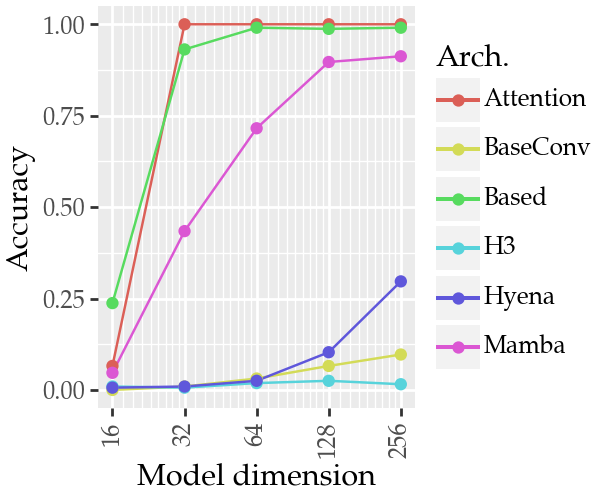

/juice2/scr2/aryaman/tinylang/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 3 x 2.5 in image.
/juice2/scr2/aryaman/tinylang/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: figs/ar_32.pdf


In [8]:
# subset_df = df[(df["variable"] == "query_item.argmax") & (df["step_rel"] == 1.0)]
# subset_df["dataset"] = subset_df["dataset"].apply(lambda x: x.replace("_nope", ""))
subset_df_best["clean"] = subset_df_best["value"].apply(lambda x: f"{x * 100:.2f}")

plot = (
    p9.ggplot(subset_df_best, p9.aes(x="dim", y="value", group="arch", color="arch")) +
    p9.geom_line() +
    p9.geom_point() +
    # p9.geom_text(p9.aes(label="clean")) +
    # p9.facet_wrap("~dataset") +
    p9.scale_x_log10(breaks=[16, 32, 64, 128, 256]) +
    p9.labs(y="Accuracy", x="Model dimension", color="Arch.") +
    p9.theme(figure_size=(3, 2.5), legend_position="right")
)
plot.show()
plot.save("figs/ar_32.pdf")

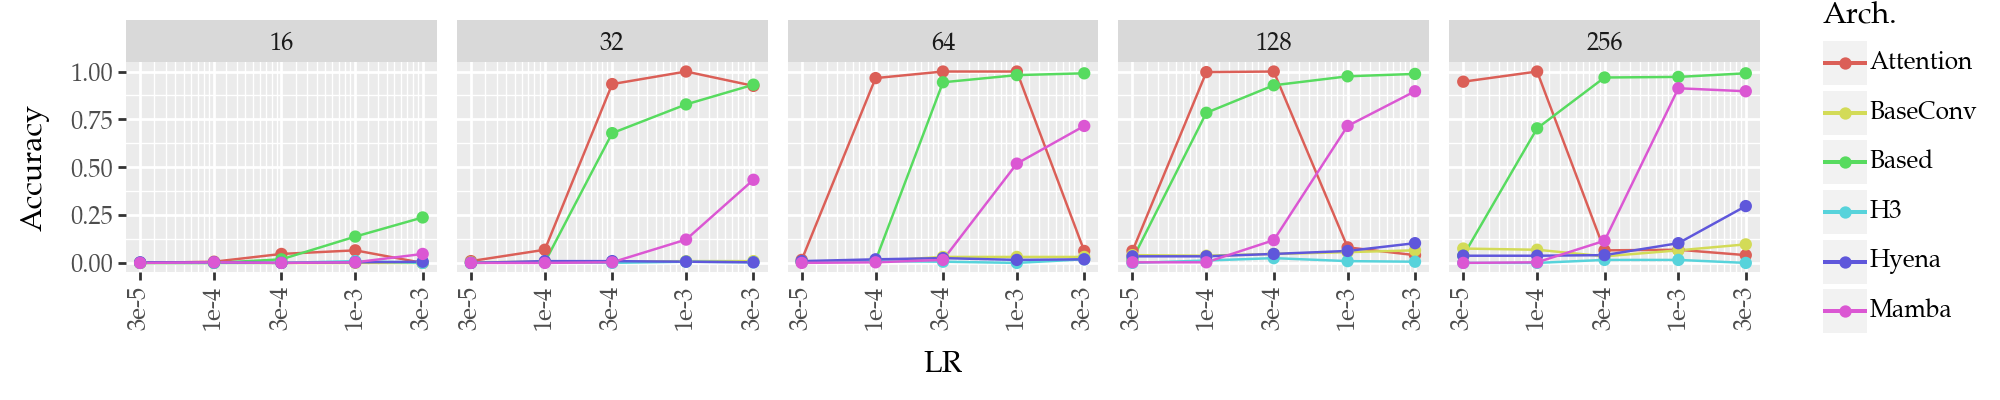

In [9]:
plot = (
    p9.ggplot(subset_df, p9.aes(x="lr", y="value", group="arch", color="arch")) +
    p9.geom_line() +
    p9.geom_point() +
    p9.facet_wrap("~dim", nrow=1) +
    p9.scale_x_log10(breaks=[3e-5, 1e-4, 3e-4, 1e-3, 3e-3]) +
    p9.labs(y="Accuracy", x="LR", color="Arch.") +
    p9.theme(figure_size=(10, 2))
)
plot.show()

In [10]:
dirs = [
    "../experiments/logs/ar_32/attention**/test/InterchangeEvaluator.csv",
    # "../experiments/logs/ar_32_nope/attention**/test/InterchangeEvaluator.csv",
    "../experiments/logs/ar_32_nope/h**/test/InterchangeEvaluator.csv",
    "../experiments/logs/ar_32_nope/b**/test/InterchangeEvaluator.csv",
    "../experiments/logs/ar_32_nope/m**/test/InterchangeEvaluator.csv",
]
df_int = read_df(dirs)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:45<00:00,  3.30it/s]


149


In [58]:
positions = ["target_item_orig", "query_item_orig", "query_item", "divider"]

# get pivoted df
def get_attrib_df(df, df_int, corruption: str="query_item_orig", components: str | list[str]="block_input", prefix="KEY"):
    if isinstance(components, str):
        components = [components]
        
    subset_df = df[(df["variable"].isin(["query_item.argmax", "query_item.pred_prob"])) & (df["step_rel"] == 1.0)]
    subset_df_int = df_int[(df_int["step_rel"] == 1.0)]
    subset_df_int = pd.concat([subset_df_int, subset_df])
    subset_df_int["dataset"] = subset_df_int["dataset"].apply(lambda x: x.replace("_nope", ""))
    subset_df_int = subset_df_int[["dim", "arch", "lr", "variable", "value", "dataset"]].pivot(index=["dim", "arch", "lr", "dataset"], columns="variable").reset_index()
    subset_df_int.columns = [col[1] if col[1] != '' else col[0] for col in subset_df_int.columns]
    
    for component in components:
        for layer in range(2):
            for position in positions:
                metric = f"{layer}.{prefix}.{corruption}.{position}.{component}.restored_prob"
                corrupted = f"corrupted.{prefix}.{corruption}.{position}.{component}.restored_prob"
                diff = f"{layer}.{prefix}.{corruption}.{position}.{component}.prob_diff"
                original = f"original.{prefix}.{corruption}.{position}.{component}.restored_prob"
                kl_div = f"{layer}.{prefix}.{corruption}.{position}.{component}.kl_div"
                label = f"Association @ {layer}, {position}" if len(components) == 1 else f"Association @ {layer}, {position}, {component}"
                subset_df_int[label] = (subset_df_int[diff]) / (subset_df_int[original] - (subset_df_int[metric] - subset_df_int[diff]))
                
        for layer in range(2):
            for position in positions:
                metric = f"{layer}.{prefix}.{corruption}.{position}.{component}.restored_prob"
                corrupted = f"corrupted.{prefix}.{corruption}.{position}.{component}.restored_prob"
                diff = f"{layer}.{prefix}.{corruption}.{position}.{component}.prob_diff"
                original = f"original.{prefix}.{corruption}.{position}.{component}.restored_prob"
                kl_div = f"{layer}.{prefix}.{corruption}.{position}.{component}.kl_div"
                suffix = f"{layer}, {position}" if len(components) == 1 else f"{layer}, {position}, {component}"
                subset_df_int = subset_df_int.rename(columns={
                    metric: f"Restored @ {suffix}",
                    corrupted: f"Corrupted @ {suffix}",
                    diff: f"Diff @ {suffix}",
                    original: f"Original @ {suffix}",
                    kl_div: f"KL @ {suffix}",
                })

    subset_df_int = subset_df_int.rename(columns={
        "query_item.argmax": "Accuracy",
        "query_item.pred_prob": "Likelihood",
    })

    return subset_df_int

subset_df_int = get_attrib_df(df, df_int)
subset_df_int_best = subset_df_int.iloc[subset_df_int.groupby(["dim", "arch", "dataset"])["Accuracy"].idxmax().dropna()].reset_index() # get most accurate ones

pivoted = subset_df_int_best.copy()[["dim", "arch", "dataset", "Association @ 1, target_item_orig"]]
pivoted["Association @ 1, target_item_orig"] = pivoted["Association @ 1, target_item_orig"].apply(lambda x: f"{x * 100:.2f}".replace("%", "\%"))
pivoted = pivoted.pivot(index=["arch"], columns=["dataset", "dim"]).sort_index(axis=1)
print(pivoted.to_latex())

\begin{tabular}{llllll}
\toprule
 & \multicolumn{5}{r}{Association @ 1, target_item_orig} \\
dataset & \multicolumn{5}{r}{ar_32} \\
dim & 16 & 32 & 64 & 128 & 256 \\
arch &  &  &  &  &  \\
\midrule
Attention & 220.13 & 100.00 & 100.00 & 100.00 & 100.00 \\
BaseConv & -3.24 & 35.89 & 165.75 & 67.26 & 204.15 \\
Based & 100.07 & 99.91 & 100.00 & 100.00 & 100.07 \\
H3 & -1.50 & -0.64 & 0.08 & 9.09 & 3.61 \\
Hyena & -0.15 & -0.62 & 62.56 & -0.00 & -0.00 \\
Mamba & 0.03 & 0.11 & -0.00 & 0.00 & 0.00 \\
\bottomrule
\end{tabular}



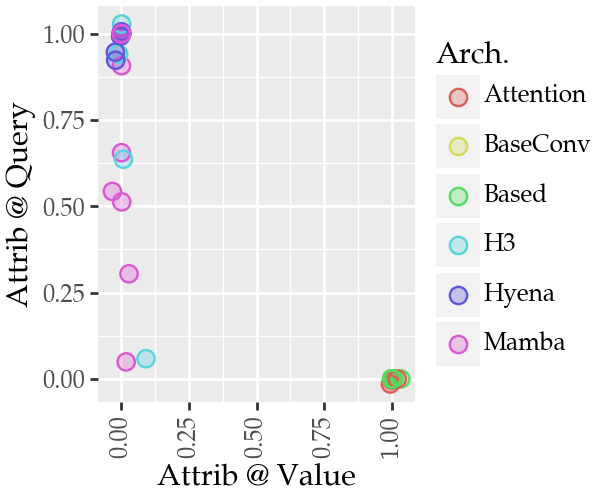

/juice2/scr2/aryaman/tinylang/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 3 x 2.5 in image.
/juice2/scr2/aryaman/tinylang/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: figs/ar_32_diff_query_item_orig.pdf


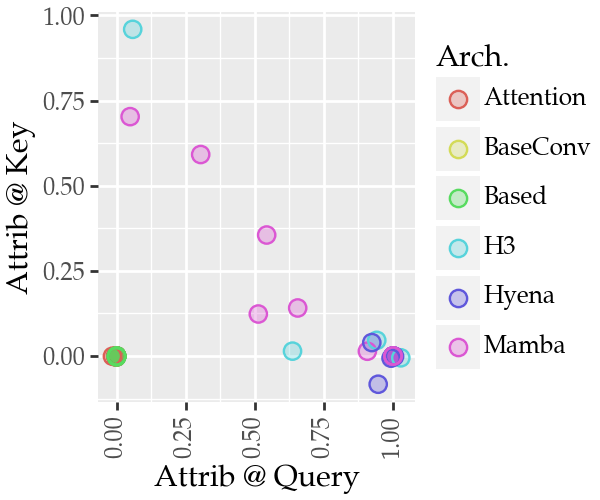

/juice2/scr2/aryaman/tinylang/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 3 x 2.5 in image.
/juice2/scr2/aryaman/tinylang/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: figs/ar_32_diff_query_item_orig_q.pdf


In [59]:
subset_df_int_plot = subset_df_int.copy()
subset_df_int_plot = subset_df_int_plot[(subset_df_int_plot["Original @ 0, target_item_orig"] - subset_df_int_plot["Corrupted @ 0, target_item_orig"]) > 0.005]
subset_df_int_plot["arch"] = pd.Categorical(subset_df_int_plot["arch"], categories=list(subset_df_int["arch"].unique()))
subset_df_int_plot["dim"] = pd.Categorical(subset_df_int_plot["dim"], categories=[x for x in sorted(subset_df_int_plot["dim"].unique())], ordered=True)
plot = (
    p9.ggplot(subset_df_int_plot, p9.aes(x="Association @ 1, target_item_orig", y="Association @ 1, query_item", color="arch", group="arch")) +
    # p9.facet_wrap("~dataset") +
    # p9.geom_path(linetype="dashed") + 
    p9.geom_point(stroke=0, alpha=0.3, size=3) + 
    p9.geom_point(fill="none", stroke=0.5, size=3) + 
    # p9.scale_x_log10() +
    p9.theme(figure_size=(6, 4)) +
    p9.labs(color="Arch.", shape="Dim.", x="Attrib @ Value", y="Attrib @ Query") +
    p9.theme(figure_size=(3, 2.5))
)
plot.show()
plot.save(f"figs/ar_32_diff_query_item_orig.pdf")

plot = (
    p9.ggplot(subset_df_int_plot, p9.aes(x="Association @ 1, query_item", y="Association @ 1, query_item_orig", color="arch", group="arch")) +
    # p9.facet_wrap("~dataset") +
    # p9.geom_path(linetype="dashed") + 
    p9.geom_point(stroke=0, alpha=0.3, size=3) + 
    p9.geom_point(fill="none", stroke=0.5, size=3) + 
    # p9.scale_x_log10() +
    p9.theme(figure_size=(6, 4)) +
    p9.labs(color="Arch.", shape="Dim.", x="Attrib @ Query", y="Attrib @ Key") +
    p9.theme(figure_size=(3, 2.5))
)
plot.show()
plot.save(f"figs/ar_32_diff_query_item_orig_q.pdf")

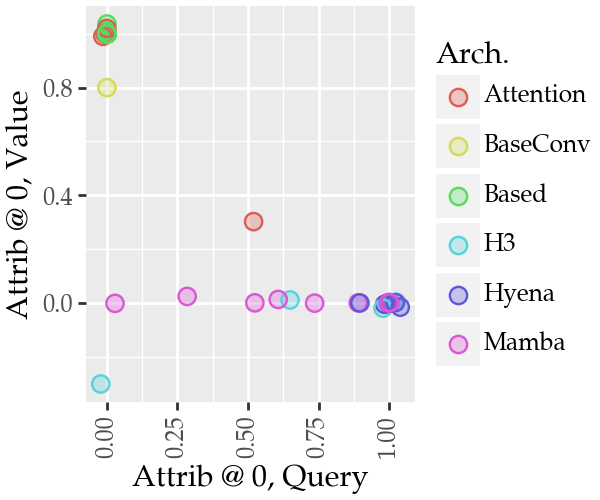

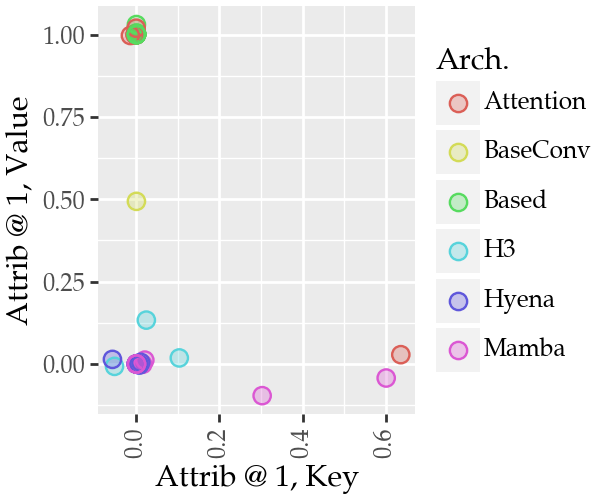

In [61]:
subset_df_int_plot = get_attrib_df(df, df_int, components=["attention_input", "attention_output"])
subset_df_int_plot = subset_df_int_plot[(subset_df_int_plot["Original @ 0, target_item_orig, attention_input"] - subset_df_int_plot["Corrupted @ 0, target_item_orig, attention_input"]) > 0.005]
subset_df_int_plot["arch"] = pd.Categorical(subset_df_int_plot["arch"], categories=list(subset_df_int["arch"].unique()))
subset_df_int_plot["dim"] = pd.Categorical(subset_df_int_plot["dim"], categories=[x for x in sorted(subset_df_int_plot["dim"].unique())], ordered=True)

plot = (
    p9.ggplot(subset_df_int_plot, p9.aes(x="Association @ 0, query_item, attention_output", y="Association @ 0, target_item_orig, attention_output", color="arch", group="arch")) +
    # p9.facet_wrap("~dataset") +
    # p9.geom_path(linetype="dashed") + 
    p9.geom_point(stroke=0, alpha=0.3, size=3) + 
    p9.geom_point(fill="none", stroke=0.5, size=3) + 
    # p9.scale_x_log10() +
    p9.theme(figure_size=(6, 4)) +
    p9.labs(color="Arch.", shape="Dim.", x="Attrib @ 0, Query", y="Attrib @ 0, Value") +
    p9.theme(figure_size=(3, 2.5))
)
plot.show()

plot = (
    p9.ggplot(subset_df_int_plot, p9.aes(x="Association @ 1, query_item, attention_input", y="Association @ 1, target_item_orig, attention_input", color="arch", group="arch")) +
    # p9.facet_wrap("~dataset") +
    # p9.geom_path(linetype="dashed") + 
    p9.geom_point(stroke=0, alpha=0.3, size=3) + 
    p9.geom_point(fill="none", stroke=0.5, size=3) + 
    # p9.scale_x_log10() +
    p9.theme(figure_size=(6, 4)) +
    p9.labs(color="Arch.", shape="Dim.", x="Attrib @ 1, Key", y="Attrib @ 1, Value") +
    p9.theme(figure_size=(3, 2.5))
)
plot.show()

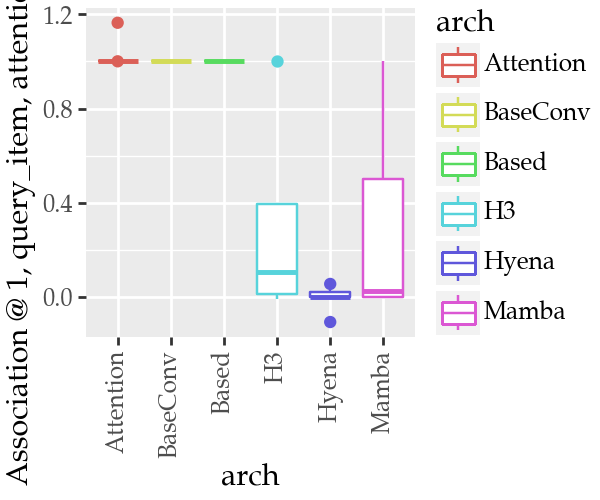

In [80]:
plot = (
    p9.ggplot(subset_df_int_plot, p9.aes(x="arch", y="Association @ 1, query_item, attention_output", color="arch", group="arch")) +
    # p9.facet_wrap("~dataset") +
    # p9.geom_path(linetype="dashed") + 
    p9.geom_boxplot() +
    # p9.scale_x_log10() +
    p9.theme(figure_size=(6, 4)) +
    # p9.labs(color="Arch.", shape="Dim.", x="Attrib @ 1, Key", y="Attrib @ 1, Value") +
    p9.theme(figure_size=(3, 2.5))
)
plot.show()

## Benchmarking ATR, varying $L$

In [81]:
dirs = [
    "../experiments/logs/pcfg_easy/attention**/test/SummaryEvaluator.csv",
    # "../experiments/logs/pcfg_easy_nope/attention**/test/SummaryEvaluator.csv",
    "../experiments/logs/pcfg_medium/attention**/test/SummaryEvaluator.csv",
    "../experiments/logs/pcfg_easy_nope/h**/test/SummaryEvaluator.csv",
    "../experiments/logs/pcfg_easy_nope/b**/test/SummaryEvaluator.csv",
    "../experiments/logs/pcfg_easy_nope/m**/test/SummaryEvaluator.csv",
    "../experiments/logs/pcfg_medium_nope/h**/test/SummaryEvaluator.csv",
    "../experiments/logs/pcfg_medium_nope/b**/test/SummaryEvaluator.csv",
    "../experiments/logs/pcfg_medium_nope/m**/test/SummaryEvaluator.csv",
    "../experiments/logs/pcfg_easy_8192/**/test/SummaryEvaluator.csv",
]
df = read_df(dirs)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 423/423 [01:14<00:00,  5.71it/s]


423


In [82]:
subset_df = df[(df["variable"] == "query_item.argmax") & (df["step_rel"] == 1.0)]
subset_df["arch"] = subset_df.apply(lambda row: "Attention (NoPE)" if (row["arch"] == "Attention" and "_nope" in row["dataset"]) else row["arch"], axis=1)
subset_df["dataset"] = subset_df["dataset"].apply(lambda x: x.replace("_nope", ""))
subset_df = subset_df[["dim", "arch", "value", "dataset"]].groupby(["dim", "arch", "dataset"]).max().reset_index()

pivoted = subset_df.copy()
pivoted
pivoted["value"] = pivoted["value"].apply(lambda x: f"{x * 100:.2f}".replace("%", "\%"))
pivoted = pivoted.pivot(index=["arch"], columns=["dataset", "dim"]).sort_index(axis=1)
print(pivoted.to_latex())

\begin{tabular}{llllllllllllllll}
\toprule
 & \multicolumn{15}{r}{value} \\
dataset & \multicolumn{5}{r}{pcfg_easy} & \multicolumn{5}{r}{pcfg_easy_8192} & \multicolumn{5}{r}{pcfg_medium} \\
dim & 16 & 32 & 64 & 128 & 256 & 16 & 32 & 64 & 128 & 256 & 16 & 32 & 64 & 128 & 256 \\
arch &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
Attention & 68.44 & 90.31 & 93.75 & 95.31 & 96.25 & 72.50 & 84.06 & 89.38 & 86.88 & 86.56 & 50.94 & 56.88 & 75.62 & 80.62 & 80.94 \\
BaseConv & 67.50 & 75.62 & 82.50 & 86.88 & 90.00 & 42.50 & 46.56 & 55.94 & 59.69 & 66.25 & 55.94 & 61.56 & 65.31 & 70.62 & 68.75 \\
Based & 82.19 & 91.25 & 91.88 & 93.12 & 92.19 & 68.44 & 83.12 & 86.56 & 87.50 & 86.56 & 63.12 & 71.56 & 70.00 & 70.94 & 73.12 \\
H3 & 81.88 & 87.81 & 90.00 & 94.06 & 94.06 & 49.38 & 63.44 & 72.50 & 75.94 & 76.25 & NaN & NaN & NaN & NaN & NaN \\
Hyena & 75.94 & 80.94 & 85.31 & 92.50 & 93.75 & 45.94 & 57.81 & 64.69 & 69.06 & 70.00 & 57.81 & 63.75 & 62.50 & 66.25 & 68.44 \\
Mamba & 91.25 & 94.38

/tmp/aryaman/ipykernel_1076521/765897195.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/aryaman/ipykernel_1076521/765897195.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


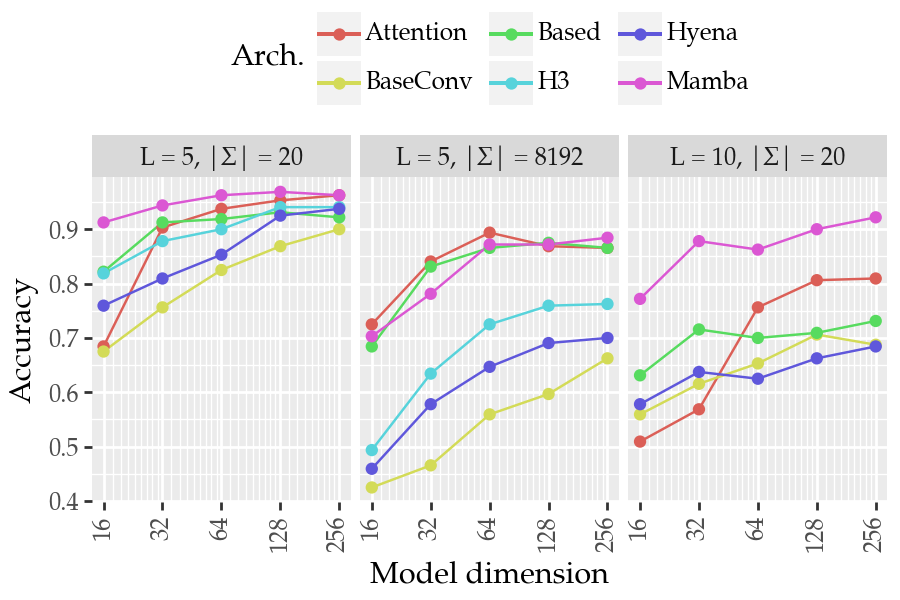

/juice2/scr2/aryaman/tinylang/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 4.5 x 3 in image.
/juice2/scr2/aryaman/tinylang/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: figs/atr.pdf


In [83]:
subset_df_plot = subset_df.copy()
subset_df_plot["dataset"] = subset_df_plot["dataset"].map({
    "pcfg_easy": "L = 5, |Σ| = 20",
    "pcfg_easy_8192": "L = 5, |Σ| = 8192",
    "pcfg_medium": "L = 10, |Σ| = 20"
})
subset_df_plot["dataset"] = pd.Categorical(subset_df_plot["dataset"], categories=["L = 5, |Σ| = 20", "L = 5, |Σ| = 8192", "L = 10, |Σ| = 20"], ordered=True)
plot = (
    p9.ggplot(subset_df_plot, p9.aes(x="dim", y="value", group="arch", color="arch")) +
    p9.geom_line() +
    p9.geom_point() +
    p9.facet_wrap("~dataset") +
    p9.scale_x_log10(breaks=[16, 32, 64, 128, 256]) +
    p9.labs(y="Accuracy", x="Model dimension", color="Arch.") +
    p9.theme(figure_size=(4.5, 3), legend_position="top")
)
plot.show()
plot.save("figs/atr.pdf")

In [84]:
dirs = [
    "../experiments/logs/pcfg_easy/attention**/test/InterchangeEvaluator.csv",
    "../experiments/logs/pcfg_medium/attention**/test/InterchangeEvaluator.csv",
    "../experiments/logs/pcfg_easy_nope/h**/test/InterchangeEvaluator.csv",
    "../experiments/logs/pcfg_easy_nope/b**/test/InterchangeEvaluator.csv",
    "../experiments/logs/pcfg_easy_nope/m**/test/InterchangeEvaluator.csv",
    "../experiments/logs/pcfg_medium_nope/h**/test/InterchangeEvaluator.csv",
    "../experiments/logs/pcfg_medium_nope/b**/test/InterchangeEvaluator.csv",
    "../experiments/logs/pcfg_medium_nope/m**/test/InterchangeEvaluator.csv",
    "../experiments/logs/pcfg_easy_8192/**/test/InterchangeEvaluator.csv",
]
df_int = read_df(dirs)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 423/423 [02:41<00:00,  2.62it/s]


423


In [160]:
subset_df_int = get_attrib_df(df, df_int, corruption="query_item_orig", components="block_input", prefix="PARENT")
subset_df_int_best = subset_df_int.iloc[subset_df_int.groupby(["dim", "arch", "dataset"])["Accuracy"].idxmax().dropna()].reset_index() # get most accurate ones

pivoted = subset_df_int_best.copy()[["dim", "arch", "dataset", "Association @ 1, target_item_orig"]]
pivoted["Association @ 1, target_item_orig"] = pivoted["Association @ 1, target_item_orig"].apply(lambda x: f"{x * 100:.2f}".replace("%", "\%"))
pivoted = pivoted.pivot(index=["arch"], columns=["dataset", "dim"]).sort_index(axis=1)
print(pivoted.to_latex())

\begin{tabular}{llllllllllllllll}
\toprule
 & \multicolumn{15}{r}{Association @ 1, target_item_orig} \\
dataset & \multicolumn{5}{r}{pcfg_easy} & \multicolumn{5}{r}{pcfg_easy_8192} & \multicolumn{5}{r}{pcfg_medium} \\
dim & 16 & 32 & 64 & 128 & 256 & 16 & 32 & 64 & 128 & 256 & 16 & 32 & 64 & 128 & 256 \\
arch &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
Attention & 23.09 & 109.29 & 102.24 & 107.19 & 102.69 & 93.81 & 90.00 & 99.23 & 86.36 & 84.77 & 11.55 & -23.18 & 112.20 & 117.13 & 109.59 \\
BaseConv & 39.82 & 27.36 & 51.08 & 69.12 & 68.92 & -2.83 & 18.92 & 20.37 & 28.35 & 61.02 & 49.96 & 49.33 & 52.78 & 59.49 & 77.11 \\
Based & 13.37 & 93.63 & 95.11 & 87.47 & 86.47 & 74.49 & 85.10 & 93.31 & 96.87 & 101.90 & 87.30 & 87.33 & 58.68 & 86.25 & 82.57 \\
H3 & 0.83 & 8.64 & 7.16 & 2.66 & 1.53 & -1.05 & 3.34 & 5.68 & -0.08 & -0.92 & NaN & NaN & NaN & NaN & NaN \\
Hyena & 4.97 & 11.95 & 11.46 & 0.09 & 6.77 & 23.32 & 1.20 & 7.97 & 5.70 & 0.73 & 17.33 & 3.67 & 14.48 & 5.42 & 9.01 \\
M

341


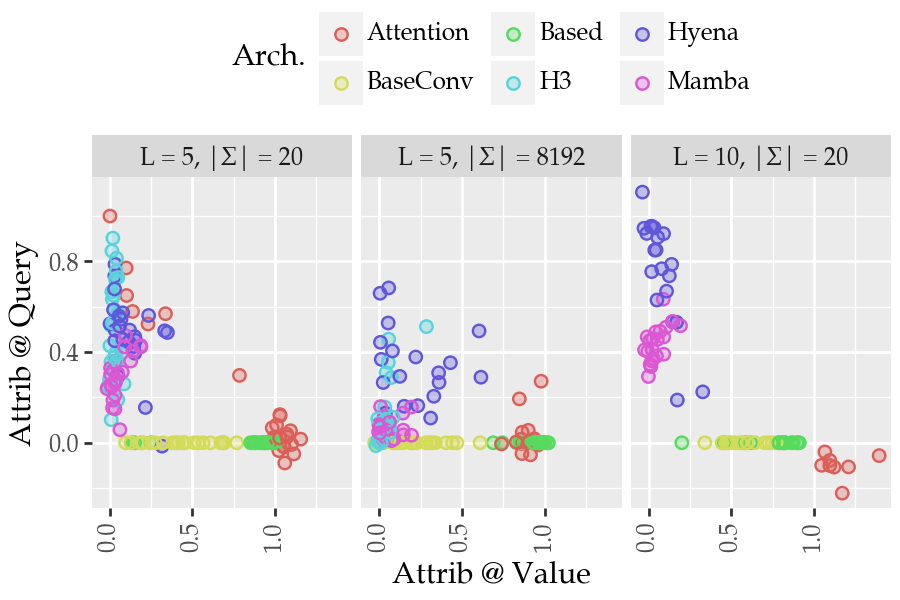

/juice2/scr2/aryaman/tinylang/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 4.5 x 3 in image.
/juice2/scr2/aryaman/tinylang/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: figs/atr_diff.pdf


In [161]:
subset_df_int_plot = subset_df_int.copy()
subset_df_int_plot = subset_df_int_plot[(subset_df_int_plot["Original @ 0, target_item_orig"] - subset_df_int_plot["Corrupted @ 0, target_item_orig"]) > 0.1]
print(len(subset_df_int_plot))
subset_df_int_plot["dataset"] = subset_df_int_plot["dataset"].map({
    "pcfg_easy": "L = 5, |Σ| = 20",
    "pcfg_easy_8192": "L = 5, |Σ| = 8192",
    "pcfg_medium": "L = 10, |Σ| = 20"
})
subset_df_int_plot["dataset"] = pd.Categorical(subset_df_int_plot["dataset"], categories=["L = 5, |Σ| = 20", "L = 5, |Σ| = 8192", "L = 10, |Σ| = 20"], ordered=True)
plot = (
    p9.ggplot(subset_df_int_plot, p9.aes(x="Association @ 1, target_item_orig", y="Association @ 1, query_item", color="arch", group="arch")) +
    p9.facet_wrap("~dataset") +
    p9.geom_point(stroke=0, alpha=0.3, size=2) + 
    p9.geom_point(fill="none", size=2, stroke=0.5) + 
    # p9.scale_x_log10() +
    p9.theme(figure_size=(4.5, 3), legend_position="top") +
    p9.labs(color="Arch.", shape="Dim.", x="Attrib @ Value", y="Attrib @ Query")
)
plot.show()
plot.save("figs/atr_diff.pdf")

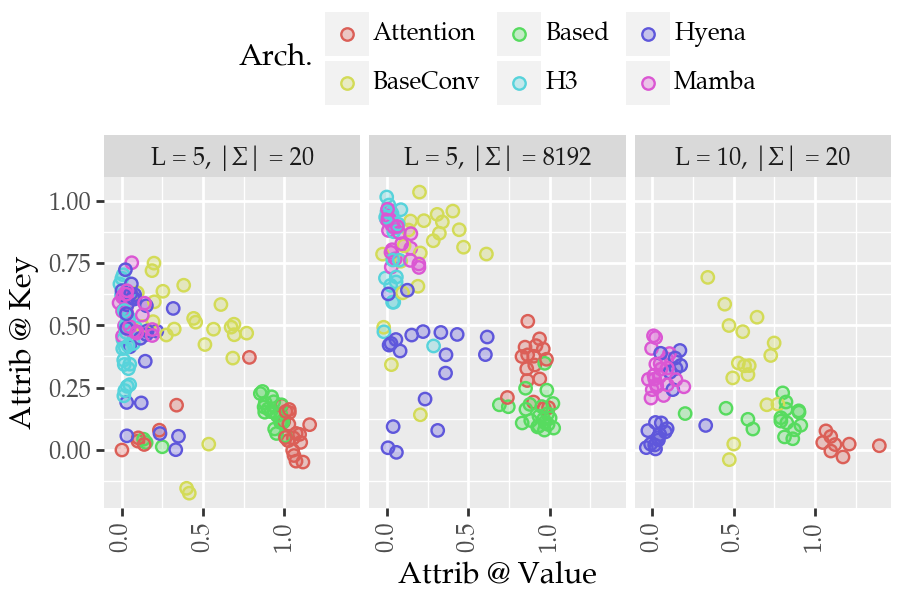

/juice2/scr2/aryaman/tinylang/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 4.5 x 3 in image.
/juice2/scr2/aryaman/tinylang/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: figs/atr_diff_q.pdf


In [164]:
plot = (
    p9.ggplot(subset_df_int_plot, p9.aes(x="Association @ 1, target_item_orig", y="Association @ 1, query_item_orig", color="arch", group="arch")) +
    p9.facet_wrap("~dataset") +
    p9.geom_point(stroke=0, alpha=0.3, size=2) + 
    p9.geom_point(fill="none", size=2, stroke=0.5) + 
    # p9.scale_x_log10() +
    p9.theme(figure_size=(4.5, 3), legend_position="top") +
    p9.labs(color="Arch.", shape="Dim.", x="Attrib @ Value", y="Attrib @ Key")
)
plot.show()
plot.save("figs/atr_diff_q.pdf")

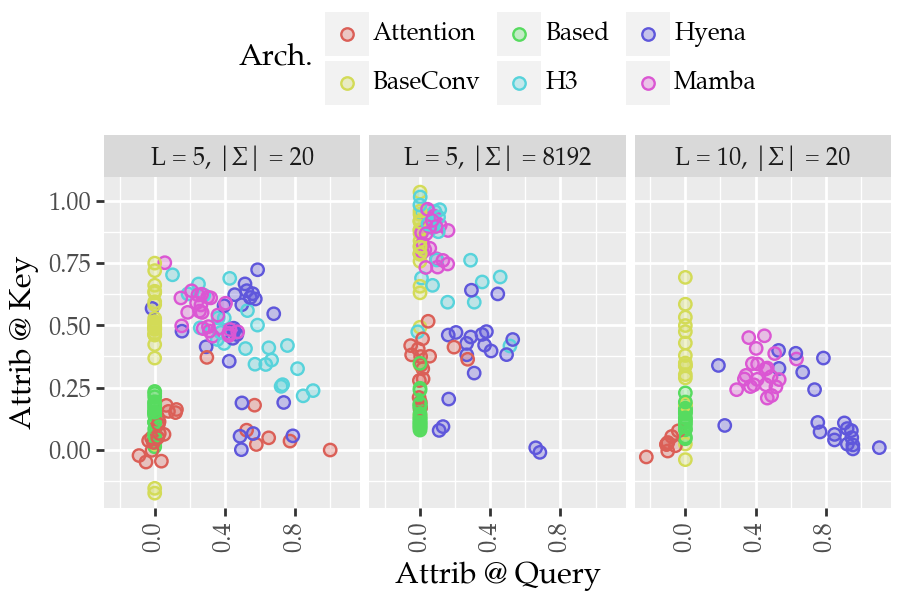

In [145]:
plot = (
    p9.ggplot(subset_df_int_plot, p9.aes(x="Association @ 1, query_item", y="Association @ 1, query_item_orig", color="arch", group="arch")) +
    p9.facet_wrap("~dataset") +
    p9.geom_point(stroke=0, alpha=0.3, size=2) + 
    p9.geom_point(fill="none", size=2, stroke=0.5) + 
    # p9.scale_x_log10() +
    p9.theme(figure_size=(4.5, 3), legend_position="top") +
    p9.labs(color="Arch.", shape="Dim.", x="Attrib @ Query", y="Attrib @ Key")
)
plot.show()
# plot.save("figs/atr_diff.pdf")

['Association @ 0, target_item_orig, attention_input', 'Association @ 0, query_item_orig, attention_input', 'Association @ 0, query_item, attention_input', 'Association @ 0, divider, attention_input']
['Association @ 0, target_item_orig, attention_output', 'Association @ 0, query_item_orig, attention_output', 'Association @ 0, query_item, attention_output', 'Association @ 0, divider, attention_output']
['Association @ 1, target_item_orig, attention_input', 'Association @ 1, query_item_orig, attention_input', 'Association @ 1, query_item, attention_input', 'Association @ 1, divider, attention_input']
['Association @ 1, target_item_orig, attention_output', 'Association @ 1, query_item_orig, attention_output', 'Association @ 1, query_item, attention_output', 'Association @ 1, divider, attention_output']


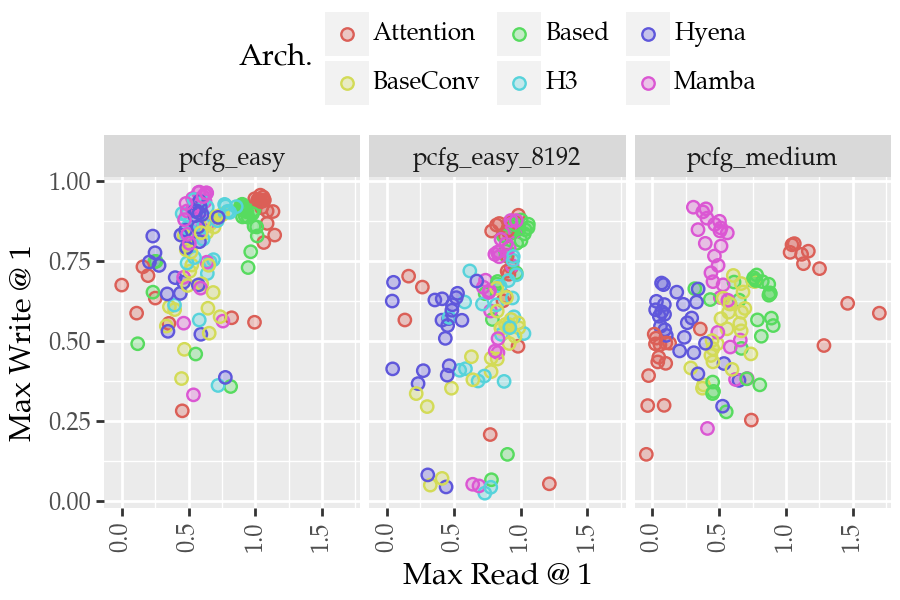

In [158]:
subset_df_int_plot = get_attrib_df(df, df_int, components=["attention_input", "attention_output", "mlp_input", "mlp_output"], prefix="PARENT")
subset_df_int_plot = subset_df_int_plot[(subset_df_int_plot["Original @ 0, target_item_orig, attention_input"] - subset_df_int_plot["Corrupted @ 0, target_item_orig, attention_input"]) > 0.005]

for layer in range(2):
    for label, component in {"Read": "attention_input", "Write": "attention_output"}.items():
        columns = [x for x in subset_df_int_plot.columns if x.startswith(f"Association @ {layer}") and x.endswith(component)]
        print(columns)
        subset_df_int_plot[f"{label} @ {layer}"] = subset_df_int_plot.apply(lambda row: max([row[col] for col in columns]), axis=1)
        
subset_df_int_plot["arch"] = pd.Categorical(subset_df_int_plot["arch"], categories=list(subset_df_int["arch"].unique()))
subset_df_int_plot["dim"] = pd.Categorical(subset_df_int_plot["dim"], categories=[x for x in sorted(subset_df_int_plot["dim"].unique())], ordered=True)

plot = (
    p9.ggplot(subset_df_int_plot, p9.aes(x="Read @ 1", y="Likelihood", color="arch", group="arch")) +
    p9.facet_wrap("~dataset") +
    p9.geom_point(stroke=0, alpha=0.3, size=2) + 
    p9.geom_point(fill="none", size=2, stroke=0.5) + 
    # p9.scale_x_log10() +
    p9.theme(figure_size=(4.5, 3), legend_position="top") +
    p9.labs(color="Arch.", shape="Dim.", x="Max Read @ 1", y="Max Write @ 1")
)
plot.show()

# plot = (
#     p9.ggplot(subset_df_int_plot, p9.aes(x="arch", y="Association @ 0, query_item_orig, attention_output", color="arch", group="arch")) +
#     p9.facet_wrap("~dataset") +
#     # p9.geom_path(linetype="dashed") + 
#     p9.geom_boxplot() +
#     # p9.scale_x_log10() +
#     # p9.labs(color="Arch.", shape="Dim.", x="Attrib @ 1, Key", y="Attrib @ 1, Value") +
#     p9.theme(figure_size=(4.5, 3), legend_position="top")
# )
# plot.show()

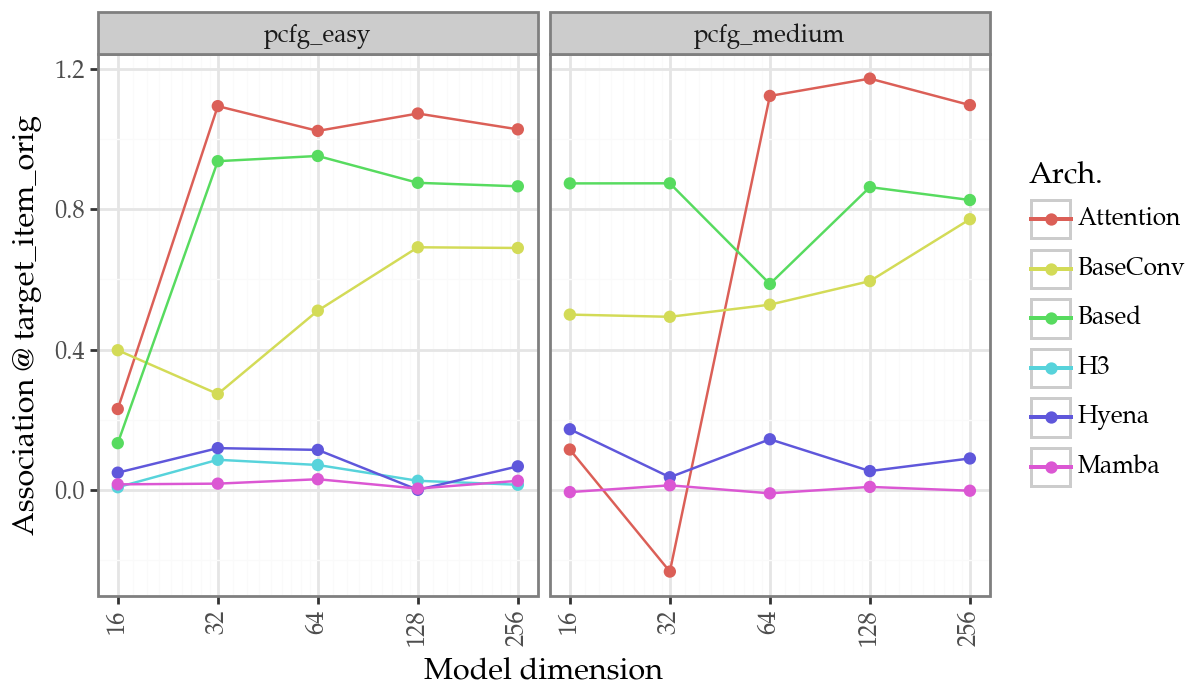

In [79]:
plot = (
    p9.ggplot(subset_df_int_best, p9.aes(x="dim", y="Association @ target_item_orig", group="arch", color="arch")) +
    p9.geom_line() +
    p9.geom_point() +
    p9.facet_wrap("~dataset") +
    p9.scale_x_log10(breaks=[16, 32, 64, 128, 256]) +
    p9.labs(y="Association @ target_item_orig", x="Model dimension", color="Arch.") +
    p9.theme(figure_size=(6, 3.5))
)
plot.show()

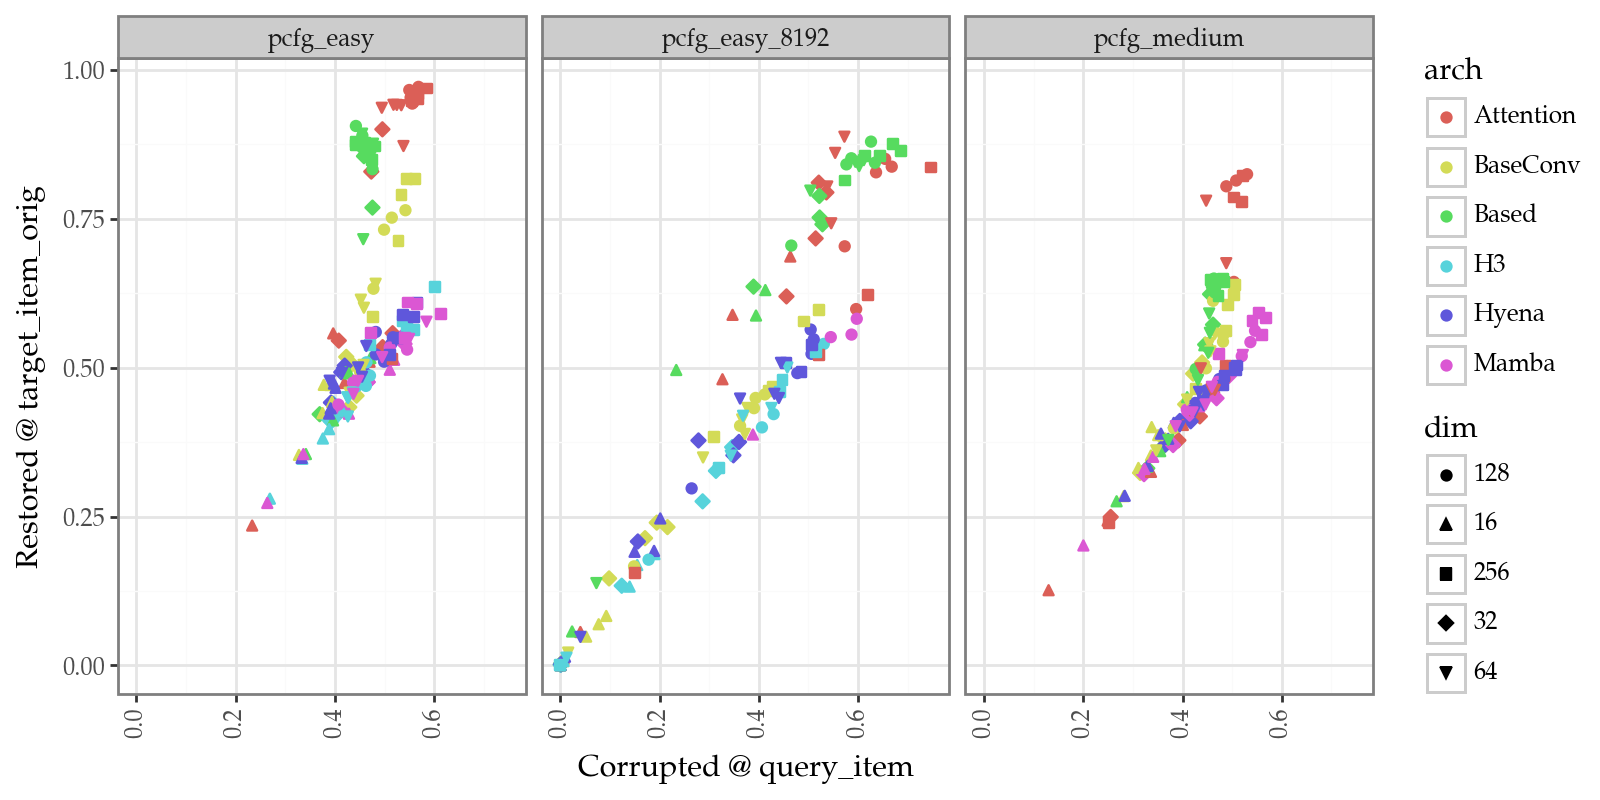

In [213]:
subset_df_int_plot = subset_df_int.copy()
subset_df_int_plot["dim"] = subset_df_int_plot["dim"].apply(lambda x: str(x))
plot = (
    p9.ggplot(subset_df_int_plot, p9.aes(x="Corrupted @ query_item", y="Restored @ target_item_orig", color="arch", group="arch", shape="dim")) +
    p9.facet_wrap("~dataset") +
    # p9.geom_path(linetype="dashed") + 
    p9.geom_point() + 
    p9.theme(figure_size=(8, 4))
)
plot.show()

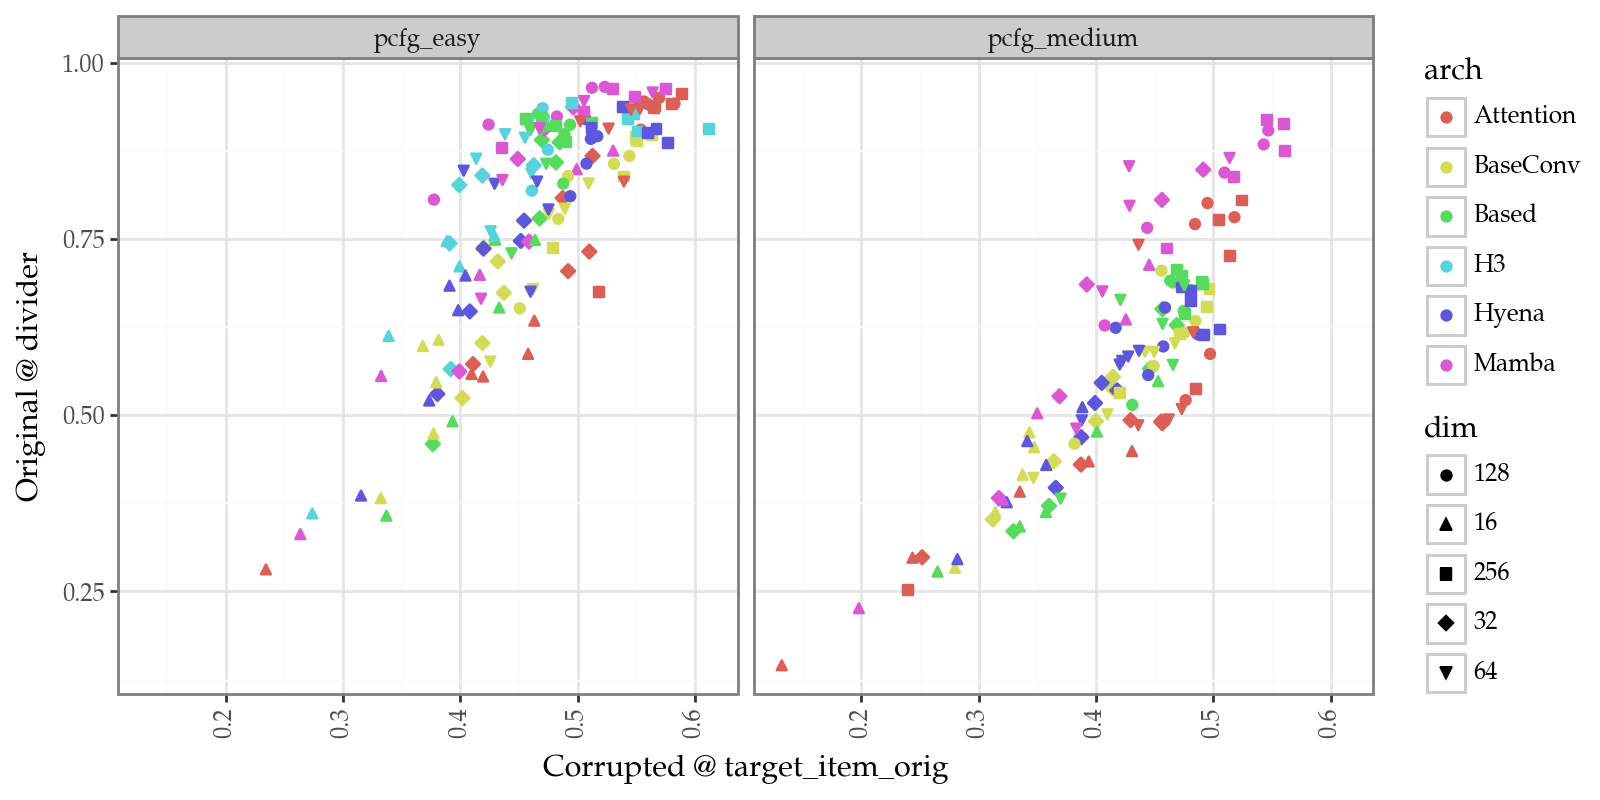

In [179]:
subset_df_int_plot = subset_df_int.copy()
subset_df_int_plot["dim"] = subset_df_int_plot["dim"].apply(lambda x: str(x))
plot = (
    p9.ggplot(subset_df_int_plot, p9.aes(x="Corrupted @ target_item_orig", y="Original @ divider", color="arch", group="arch", shape="dim")) +
    p9.facet_wrap("~dataset") +
    # p9.xlim(-0.5, 1.5) +
    # p9.ylim(-0.5, 1.5) +
    # p9.geom_path(linetype="dashed") + 
    p9.geom_point() + 
    p9.theme(figure_size=(8, 4))
)
plot.show()

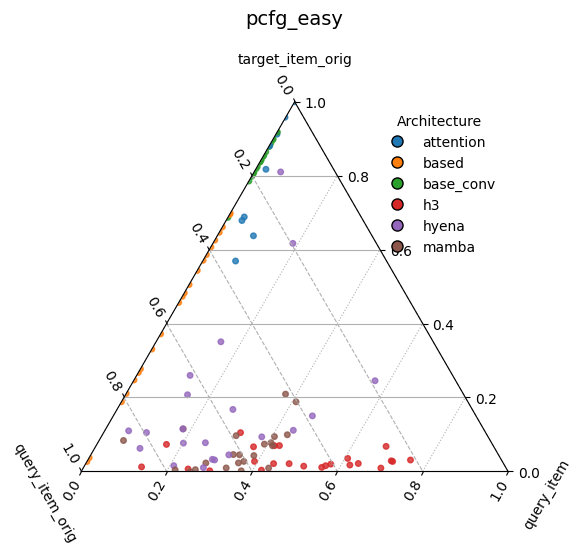

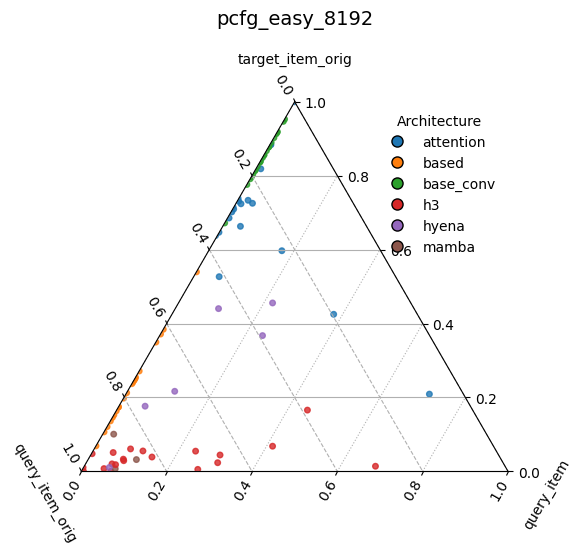

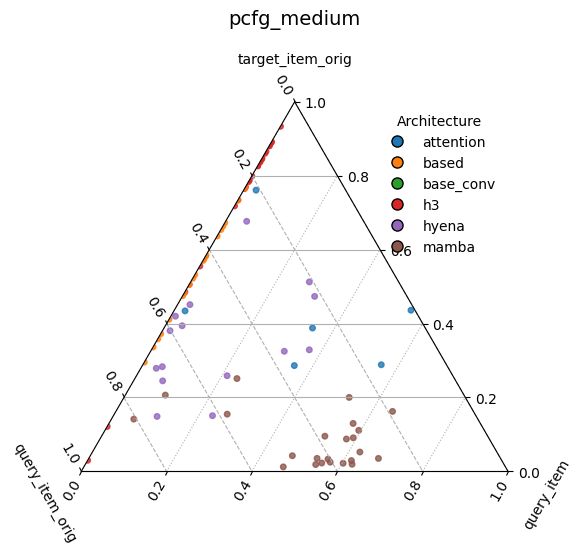

In [210]:
for dataset in subset_df_int["dataset"].unique():
    ax = plt.subplot(projection="ternary")
    dataset_df = subset_df_int[subset_df_int["dataset"] == dataset]
    t = dataset_df["Association @ target_item_orig"]
    l = dataset_df["Association @ query_item_orig"]
    r = dataset_df["Association @ query_item"]
    c = dataset_df["arch"]
    
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    colors = le.fit_transform(c)  # this gives each arch a distinct color
    
    # Use seaborn color palette (or switch to "Set3", "tab20", etc. for variety)
    from matplotlib.colors import ListedColormap
    import seaborn as sns
    palette = sns.color_palette("tab10", n_colors=len(arch_names))
    cmap = ListedColormap(palette)
    
    ax.scatter(t, l, r, s=16.0, c=colors, cmap=cmap, alpha=0.8)
    
    ax.set_tlabel("target_item_orig")
    ax.set_llabel("query_item_orig")
    ax.set_rlabel("query_item")
    
    ax.taxis.set_major_locator(MultipleLocator(0.20))
    ax.laxis.set_major_locator(MultipleLocator(0.20))
    ax.raxis.set_major_locator(MultipleLocator(0.20))
    
    # ax.laxis.set_minor_locator(MultipleLocator(0.1))
    # ax.raxis.set_minor_locator(AutoMinorLocator(5))
    
    ax.grid(axis='t', which='both')
    ax.grid(axis='l', which='both', linestyle='--')
    ax.grid(axis='r', which='both', linestyle=':')
    
    # Legend: match encoded values to palette
    handles = [
        plt.Line2D(
            [0], [0], marker='o', linestyle='None', label=label,
            markerfacecolor=palette[i], markeredgecolor='k', markersize=8
        )
        for i, label in enumerate(arch_names)
    ]
    ax.legend(handles=handles, title="Architecture", loc="upper right", frameon=False)
    ax.set_title(dataset, fontsize=14, pad=20)
    
    plt.show()
    plt.clf()

## Interpreting ATR, varying $L$

In [58]:
suffix = "_nope"
dirs = [
    # f"../experiments/logs/pcfg_easy{suffix}/**/test/InterchangeEvaluator.csv",
    # f"../experiments/logs/pcfg_medium{suffix}/**/test/InterchangeEvaluator.csv",
    "../experiments/logs/ar_32/**/test/InterchangeEvaluator.csv",
]
df_int = read_df(dirs)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:50<00:00,  2.95it/s]


150


In [61]:
position = "target_item_orig"
metric = f"1.KEY.query_item_orig.{position}.block_input.restored_prob"
corrupted = f"corrupted.KEY.query_item_orig.{position}.block_input.restored_prob"
diff = f"1.KEY.query_item_orig.{position}.block_input.prob_diff"
original = f"original.KEY.query_item_orig.{position}.block_input.restored_prob"

subset_df = df[(df["variable"] == "query_item.argmax") & (df["step_rel"] == 1.0)]
subset_df_int = df_int[(df_int["variable"].isin([metric, corrupted, diff, original])) & (df_int["step_rel"] == 1.0)]
subset_df_int = pd.concat([subset_df_int, subset_df])
subset_df_int = subset_df_int[["dim", "arch", "lr", "variable", "value", "dataset"]].pivot(index=["dim", "arch", "lr", "dataset"], columns="variable").reset_index()
subset_df_int.columns = [col[1] if col[1] != '' else col[0] for col in subset_df_int.columns]
# subset_df_int[metric] = (subset_df_int[metric] - subset_df_int[corrupted]) / (subset_df_int[original] - subset_df_int[corrupted])
subset_df_int["Association"] = (subset_df_int[diff]) / (subset_df_int[original] - (subset_df_int[metric] - subset_df_int[diff]))
subset_df_int = subset_df_int.rename(columns={
    "query_item.argmax": "Accuracy",
    metric: "Restored",
    "Association": "Association",
    corrupted: "Corrupted",
    diff: "Diff",
    original: "Original",
})
# subset_df_int[subset_df_int["arch"] == "Attention"]

subset_df_int = subset_df_int.iloc[subset_df_int.groupby(["dim", "arch", "dataset"])["Accuracy"].idxmax()].reset_index() # get most accurate ones
subset_df_int["dataset"] = subset_df_int["dataset"].map({
    f"pcfg_easy{suffix}": "$L = 5$",
    f"pcfg_medium{suffix}": "$L = 10$",
})
subset_df_int["dataset"] = pd.Categorical(subset_df_int["dataset"], categories=["$L = 5$", "$L = 10$"], ordered=True)
# subset_df_int

pivoted = subset_df_int.copy()[["dim", "arch", "dataset", "Association"]]
pivoted["Association"] = pivoted["Association"].apply(lambda x: f"{x * 100:.2f}".replace("%", "\%"))
pivoted = pivoted.pivot(index=["arch"], columns=["dataset", "dim"]).sort_index(axis=1)
print(pivoted.to_latex())

\begin{tabular}{llllll}
\toprule
 & \multicolumn{5}{r}{Association} \\
dataset & \multicolumn{5}{r}{NaN} \\
dim & 16 & 32 & 64 & 128 & 256 \\
arch &  &  &  &  &  \\
\midrule
Attention & 220.13 & 100.00 & 100.00 & 100.00 & 100.00 \\
BaseConv & -2.05 & 0.11 & -592.29 & -3.44 & 94.25 \\
Based & 101.61 & 100.64 & 100.33 & 100.28 & 100.00 \\
H3 & 7.56 & 1.35 & 8.63 & 2.83 & -2.27 \\
Hyena & -0.44 & 24.60 & -84.10 & 0.01 & 0.00 \\
Mamba & -3.72 & -0.00 & -0.00 & 0.00 & 0.00 \\
\bottomrule
\end{tabular}



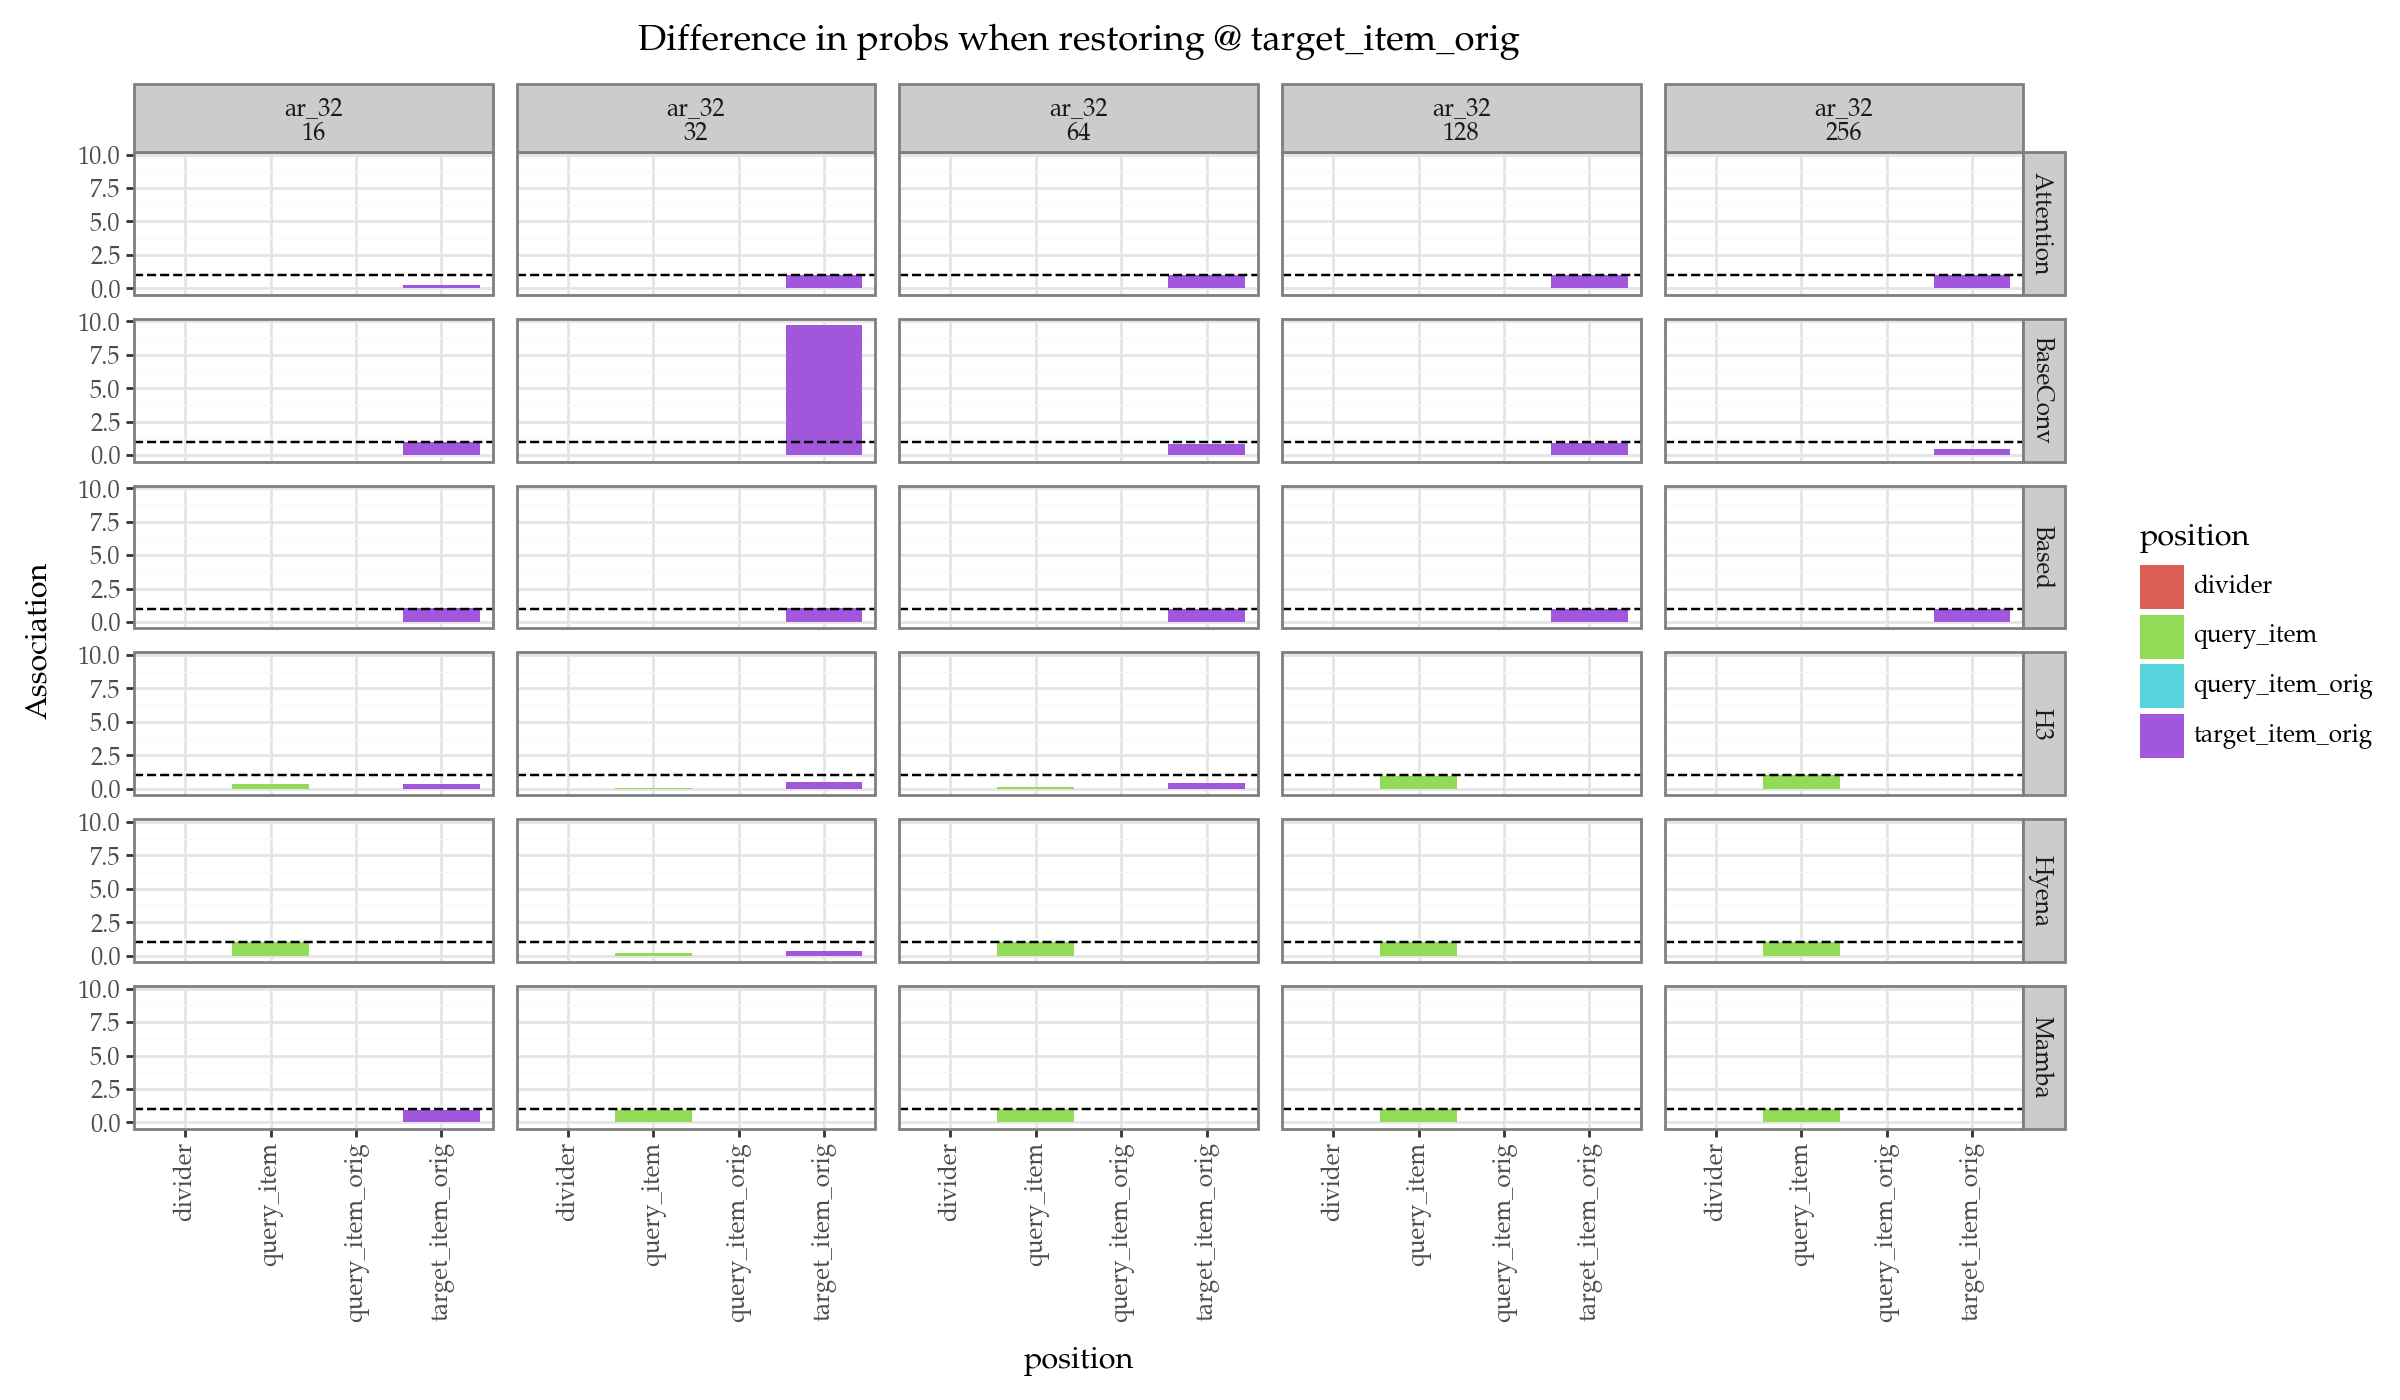

KeyError: "None of ['lr'] are in the columns"

In [66]:
pos_dfs = []
measure = "prob"
corrupt = "target_item_orig"
for position in ["target_item_orig", "query_item_orig", "query_item", "divider"]:
    metric = f"1.KEY.{corrupt}.{position}.block_input.restored_{measure}"
    corrupted = f"corrupted.KEY.{corrupt}.{position}.block_input.restored_{measure}"
    diff = f"1.KEY.{corrupt}.{position}.block_input.{measure}_diff"
    original = f"original.KEY.{corrupt}.{position}.block_input.restored_{measure}"
    
    subset_df = df[(df["variable"] == "query_item.argmax") & (df["step_rel"] == 1.0)]
    subset_df_int = df_int[(df_int["variable"].isin([metric, corrupted, diff, original])) & (df_int["step_rel"] == 1.0)]
    subset_df_int = pd.concat([subset_df_int, subset_df])
    subset_df_int = subset_df_int[["dim", "arch", "lr", "variable", "value", "dataset"]].pivot(index=["dim", "arch", "lr", "dataset"], columns="variable").reset_index()
    subset_df_int.columns = [col[1] if col[1] != '' else col[0] for col in subset_df_int.columns]
    # subset_df_int[metric] = (subset_df_int[metric] - subset_df_int[corrupted]) / (subset_df_int[original] - subset_df_int[corrupted])
    subset_df_int[metric] = (subset_df_int[diff]) / (subset_df_int[original] - (subset_df_int[metric] - subset_df_int[diff]))
    subset_df_int = subset_df_int.rename(columns={
        "query_item.argmax": "Accuracy",
        metric: "Association",
        corrupted: "Corrupted",
        diff: "Diff",
        original: "Original",
    })
    subset_df_int = subset_df_int.iloc[subset_df_int.groupby(["dim", "arch", "dataset"])["Accuracy"].idxmax()] # get most accurate ones
    # subset_df_int["dataset"] = subset_df_int["dataset"].map({
    #     f"pcfg_easy{suffix}": "$L = 5$",
    #     f"pcfg_medium{suffix}": "$L = 10$",
    # })
    # subset_df_int["dataset"] = pd.Categorical(subset_df_int["dataset"], categories=["$L = 5$", "$L = 10$"], ordered=True)
    subset_df_int["position"] = position
    pos_dfs.append(subset_df_int[["dim", "arch", "dataset", "position", "Association"]])

pos_df = pd.concat(pos_dfs)
pos_df

plot = (
    p9.ggplot(pos_df, p9.aes(x="position", y="Association", fill="position")) +
    p9.facet_grid("arch ~ dataset + dim") +
    p9.geom_bar(stat="identity") +
    p9.theme(figure_size=(12, 7)) +
    p9.geom_hline(yintercept=1, linetype="dashed") +
    p9.labs(title=f"Difference in {measure}s when restoring @ {corrupt}")
)
plot.show()
pos_df.pivot(index=["dim", "arch", "lr", "dataset"], columns=["position"])


/juice2/scr2/aryaman/tinylang/.venv/lib/python3.11/site-packages/plotnine/geoms/geom_path.py:100: PlotnineWarning: geom_path: Removed 1 rows containing missing values.


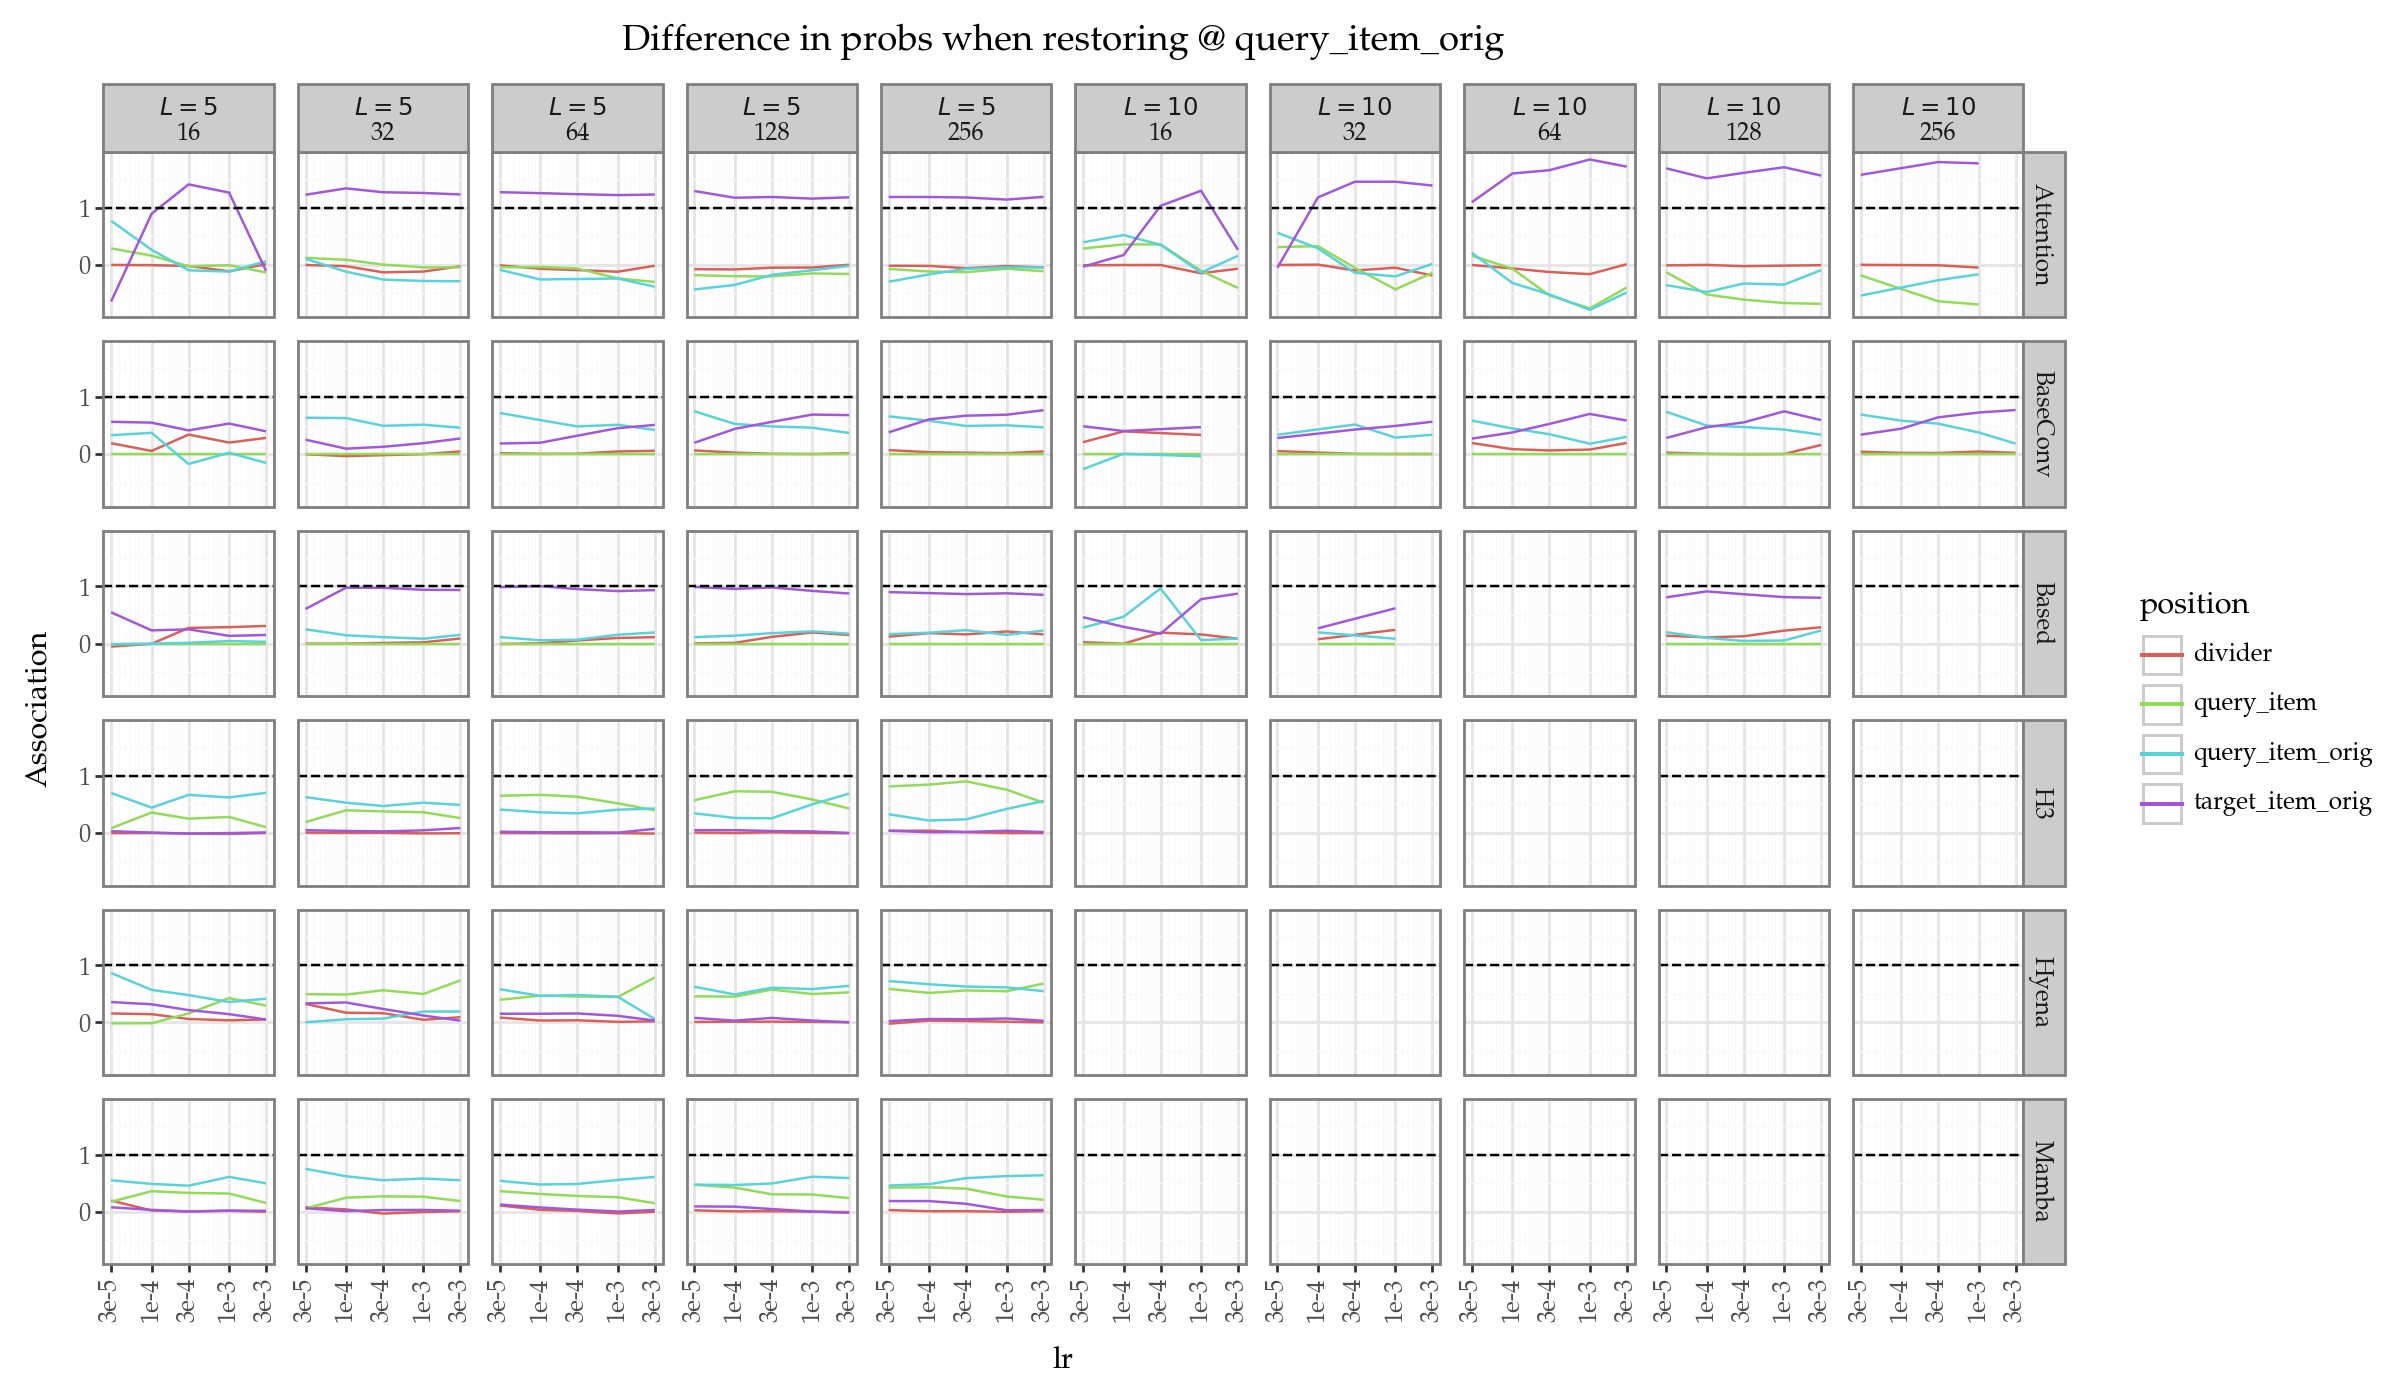

In [45]:
for position in ["target_item_orig", "query_item_orig", "query_item", "divider"]:
    metric = f"1.PARENT.{corrupt}.{position}.block_input.restored_{measure}"
    corrupted = f"corrupted.PARENT.{corrupt}.{position}.block_input.restored_{measure}"
    diff = f"1.PARENT.{corrupt}.{position}.block_input.{measure}_diff"
    original = f"original.PARENT.{corrupt}.{position}.block_input.restored_{measure}"
    
    subset_df = df[(df["variable"] == "query_item.argmax") & (df["step_rel"] == 1.0)]
    subset_df_int = df_int[(df_int["variable"].isin([metric, corrupted, diff, original])) & (df_int["step_rel"] == 1.0)]
    subset_df_int = pd.concat([subset_df_int, subset_df])
    subset_df_int = subset_df_int[["dim", "arch", "lr", "variable", "value", "dataset"]].pivot(index=["dim", "arch", "lr", "dataset"], columns="variable").reset_index()
    subset_df_int.columns = [col[1] if col[1] != '' else col[0] for col in subset_df_int.columns]
    # subset_df_int[metric] = (subset_df_int[metric] - subset_df_int[corrupted]) / (subset_df_int[original] - subset_df_int[corrupted])
    subset_df_int[metric] = (subset_df_int[diff]) / (subset_df_int[original] - (subset_df_int[metric] - subset_df_int[diff]))
    subset_df_int = subset_df_int.rename(columns={
        "query_item.argmax": "Accuracy",
        metric: "Association",
        corrupted: "Corrupted",
        diff: "Diff",
        original: "Original",
    })
    # subset_df_int = subset_df_int.iloc[subset_df_int.groupby(["dim", "arch", "dataset"])["Accuracy"].idxmax()] # get most accurate ones
    subset_df_int["dataset"] = subset_df_int["dataset"].map({
        "pcfg_easy_nope": "$L = 5$",
        "pcfg_medium_nope": "$L = 10$",
    })
    subset_df_int["dataset"] = pd.Categorical(subset_df_int["dataset"], categories=["$L = 5$", "$L = 10$"], ordered=True)
    subset_df_int["position"] = position
    pos_dfs.append(subset_df_int[["dim", "arch", "dataset", "lr", "position", "Association"]])

pos_df = pd.concat(pos_dfs)

plot = (
    p9.ggplot(pos_df, p9.aes(x="lr", y="Association", color="position", group="position")) +
    p9.facet_grid("arch ~ dataset + dim") +
    p9.geom_line() +
    # p9.geom_point() +
    p9.theme(figure_size=(12, 7)) +
    p9.geom_hline(yintercept=1, linetype="dashed") +
    p9.scale_x_log10(breaks=[3e-5, 1e-4, 3e-4, 1e-3, 3e-3]) +
    p9.labs(title=f"Difference in {measure}s when restoring @ {corrupt}")
)
plot.show()

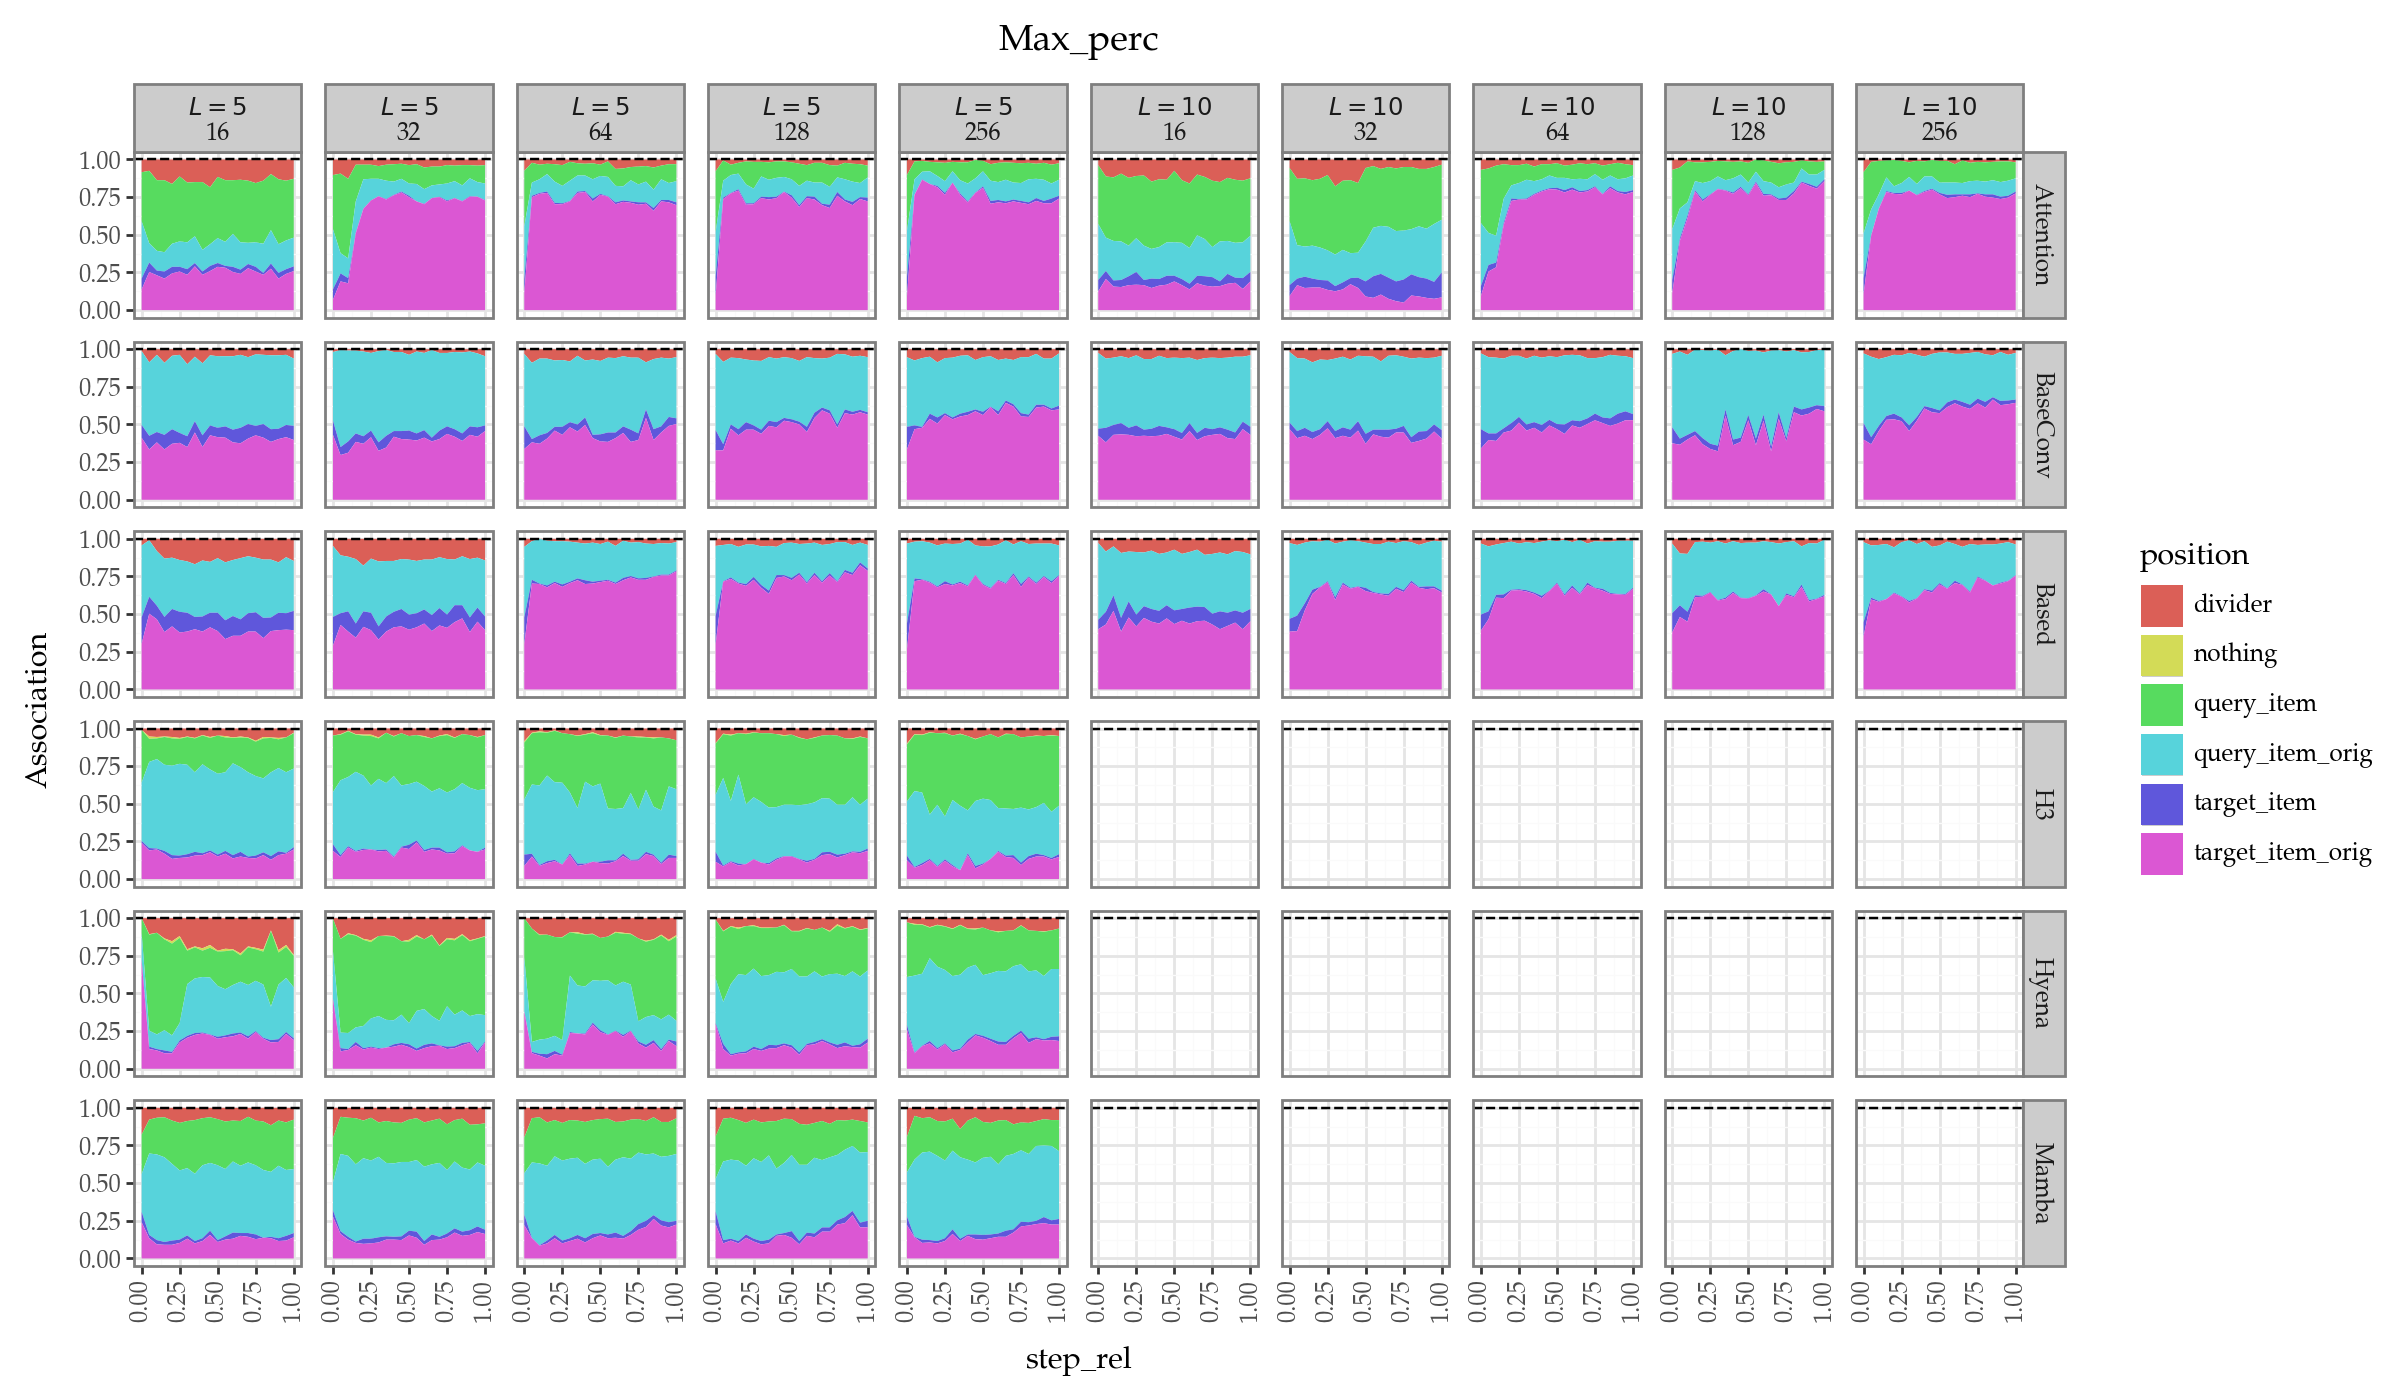

In [200]:
pos_dfs = []
measure = "prob"
corrupt = "query_item_orig"
for position in ["target_item_orig", "query_item_orig", "query_item", "divider", "nothing", "target_item"]:
    metric = f"1.PARENT.{corrupt}.{position}.block_input.max_perc"

    subset_df = df[(df["variable"] == "query_item.argmax")]# & (df["step_rel"] == 1.0)]
    subset_df_int = df_int[(df_int["variable"].isin([metric]))]# & (df_int["step_rel"] == 1.0)]
    subset_df_int = pd.concat([subset_df_int, subset_df])
    subset_df_int = subset_df_int[["dim", "arch", "lr", "variable", "value", "dataset", "step_rel"]].pivot(index=["dim", "arch", "lr", "dataset", "step_rel"], columns="variable").reset_index()
    subset_df_int.columns = [col[1] if col[1] != '' else col[0] for col in subset_df_int.columns]
    subset_df_int = subset_df_int.rename(columns={
        "query_item.argmax": "Accuracy",
        metric: "Association",
    })
    subset_df_int = subset_df_int.iloc[subset_df_int.groupby(["dim", "arch", "dataset", "step_rel"])["Accuracy"].idxmax()] # get most accurate ones
    subset_df_int["dataset"] = subset_df_int["dataset"].map({
        "pcfg_easy": "$L = 5$",
        "pcfg_medium": "$L = 10$",
    })
    subset_df_int["dataset"] = pd.Categorical(subset_df_int["dataset"], categories=["$L = 5$", "$L = 10$"], ordered=True)
    subset_df_int["position"] = position
    pos_dfs.append(subset_df_int[["dim", "arch", "dataset", "position", "Association", "step_rel"]])

pos_df = pd.concat(pos_dfs)

plot = (
    p9.ggplot(pos_df, p9.aes(x="step_rel", y="Association", fill="position")) +
    p9.facet_grid("arch ~ dataset + dim") +
    p9.geom_area(stat="identity") +
    p9.theme(figure_size=(12, 7)) +
    p9.geom_hline(yintercept=1, linetype="dashed") +
    p9.labs(title=f"Max_perc")
)
plot.show()
# pos_df.pivot(index=["dim", "arch", "lr", "dataset"], columns=["position"])


In [149]:
df["variable"].unique()

array(['PARENT.query_item.argmax', 'PARENT.query_item.kl_div',
       'PARENT.query_item.pred_prob', 'loss', 'query_item.argmax',
       'query_item.kl_div', 'query_item.pred_prob'], dtype=object)

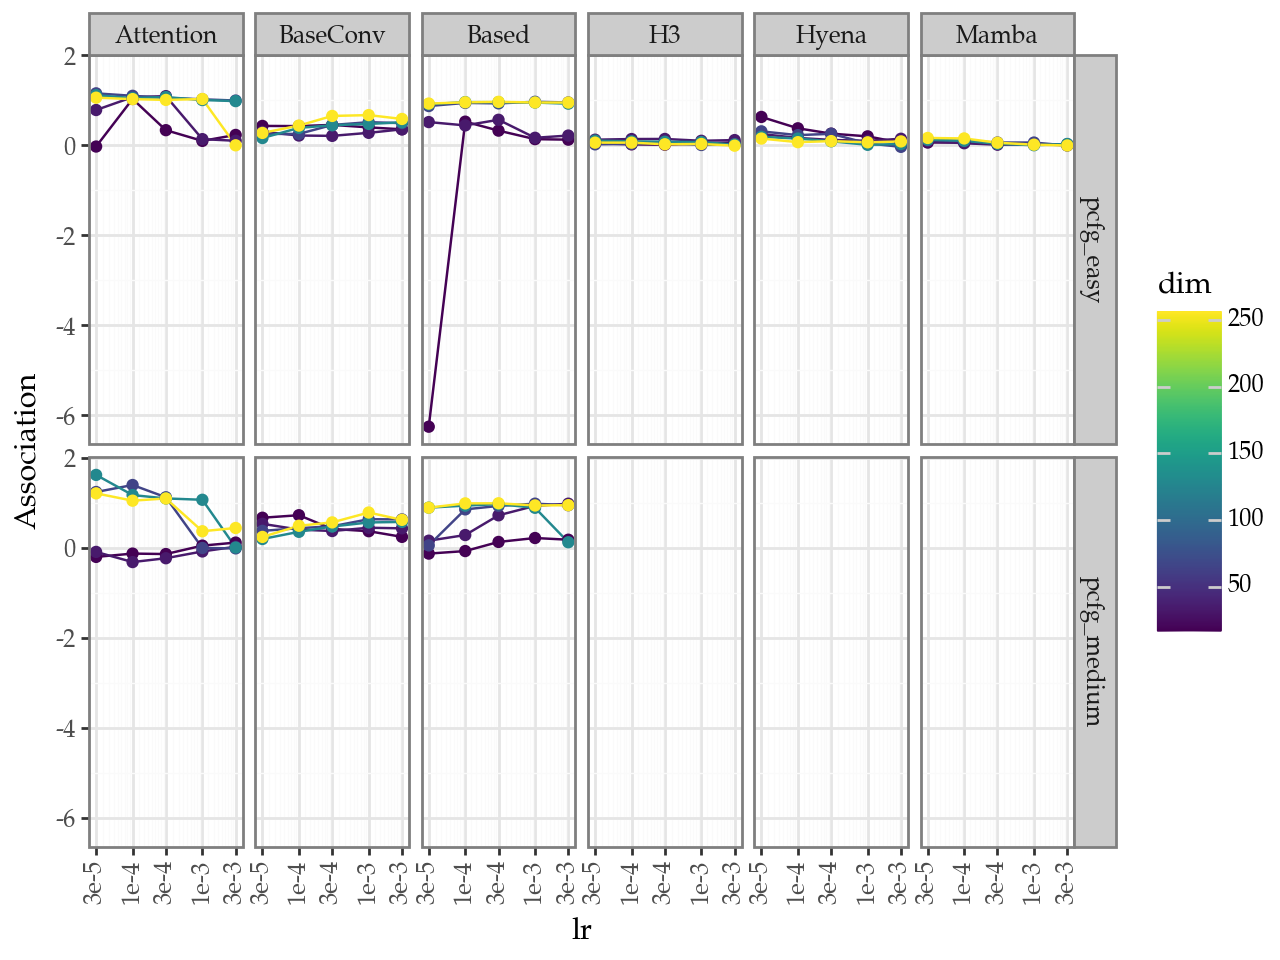

In [189]:
position = "target_item_orig"
metric = f"1.PARENT.query_item_orig.{position}.block_input.restored_prob"
corrupted = f"corrupted.PARENT.query_item_orig.{position}.block_input.restored_prob"
diff = f"1.PARENT.query_item_orig.{position}.block_input.prob_diff"
original = f"original.PARENT.query_item_orig.{position}.block_input.restored_prob"
acc = "query_item.argmax"

subset_df = df[(df["variable"] == acc) & (df["step_rel"] == 1.0)]
subset_df_int = df_int[(df_int["variable"].isin([metric, corrupted, diff, original])) & (df_int["step_rel"] == 1.0)]
subset_df_int = pd.concat([subset_df_int, subset_df])
subset_df_int = subset_df_int[["dim", "arch", "lr", "variable", "value", "dataset"]].pivot(index=["dim", "arch", "lr", "dataset"], columns="variable").reset_index()
subset_df_int.columns = [col[1] if col[1] != '' else col[0] for col in subset_df_int.columns]
# subset_df_int[metric] = (subset_df_int[metric] - subset_df_int[corrupted]) / (subset_df_int[original] - subset_df_int[corrupted])
subset_df_int[metric] = (subset_df_int[diff]) / (subset_df_int[original] - (subset_df_int[metric] - subset_df_int[diff]))
subset_df_int = subset_df_int.rename(columns={
    acc: "Accuracy",
    metric: "Association",
    corrupted: "Corrupted",
    diff: "Diff",
    original: "Original",
})
# print(subset_df_int.sort_values(by=["Association"], ascending=False))

plot = (
    p9.ggplot(subset_df_int, p9.aes(x="lr", y="Association", group="dim", color="dim")) +
    p9.facet_grid("dataset ~ arch") +
    p9.geom_line() +
    p9.geom_point() +
    p9.scale_x_log10(breaks=[3e-5, 1e-4, 3e-4, 1e-3, 3e-3])
)
plot.show()

/tmp/aryaman/ipykernel_506425/648833079.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/aryaman/ipykernel_506425/648833079.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


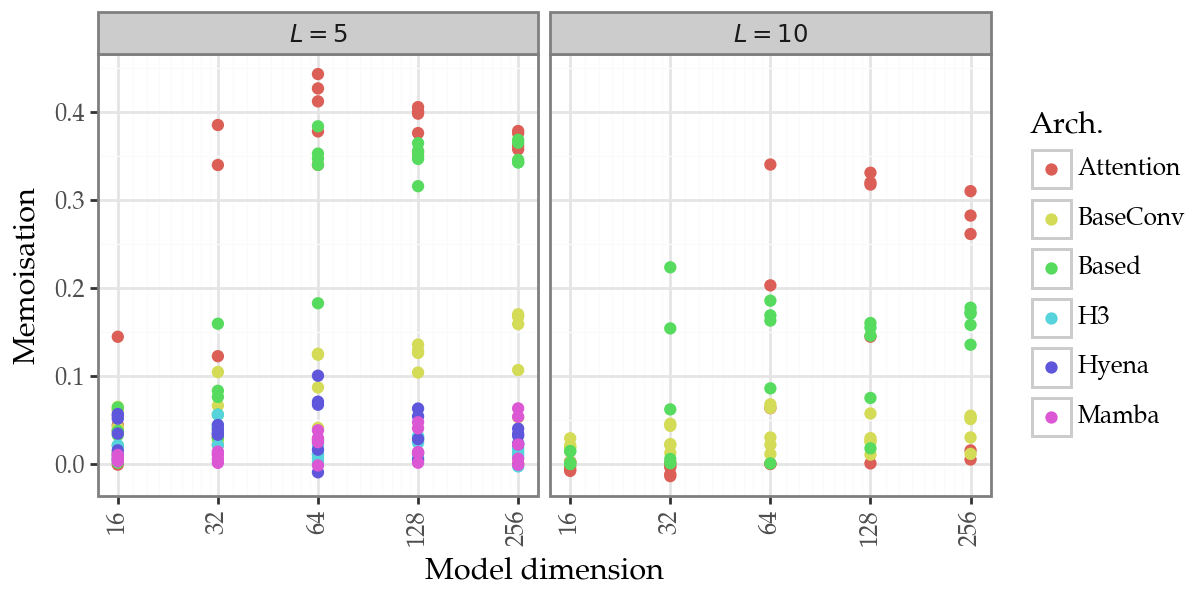

In [17]:
subset_df = df_int[(df_int["variable"] == "1.PARENT.query_item_orig.target_item_orig.block_input.prob_diff") & (df_int["step_rel"] == 1.0)]
# subset_df = subset_df[["dim", "arch", "value", "dataset"]].groupby(["dim", "arch", "dataset"]).max().reset_index()
subset_df["dataset"] = subset_df["dataset"].map({
    "pcfg_easy": "$L = 5$",
    "pcfg_medium": "$L = 10$",
})
subset_df["dataset"] = pd.Categorical(subset_df["dataset"], categories=["$L = 5$", "$L = 10$"], ordered=True)

plot = (
    p9.ggplot(subset_df, p9.aes(x="dim", y="value", group="arch", color="arch")) +
    # p9.stat_summary() +
    # p9.geom_line() +
    p9.geom_point() +
    p9.facet_wrap("~dataset") +
    p9.scale_x_log10(breaks=[16, 32, 64, 128, 256]) +
    p9.labs(y="Memoisation", x="Model dimension", color="Arch.") +
    p9.theme(figure_size=(6, 3))
)
plot.show()

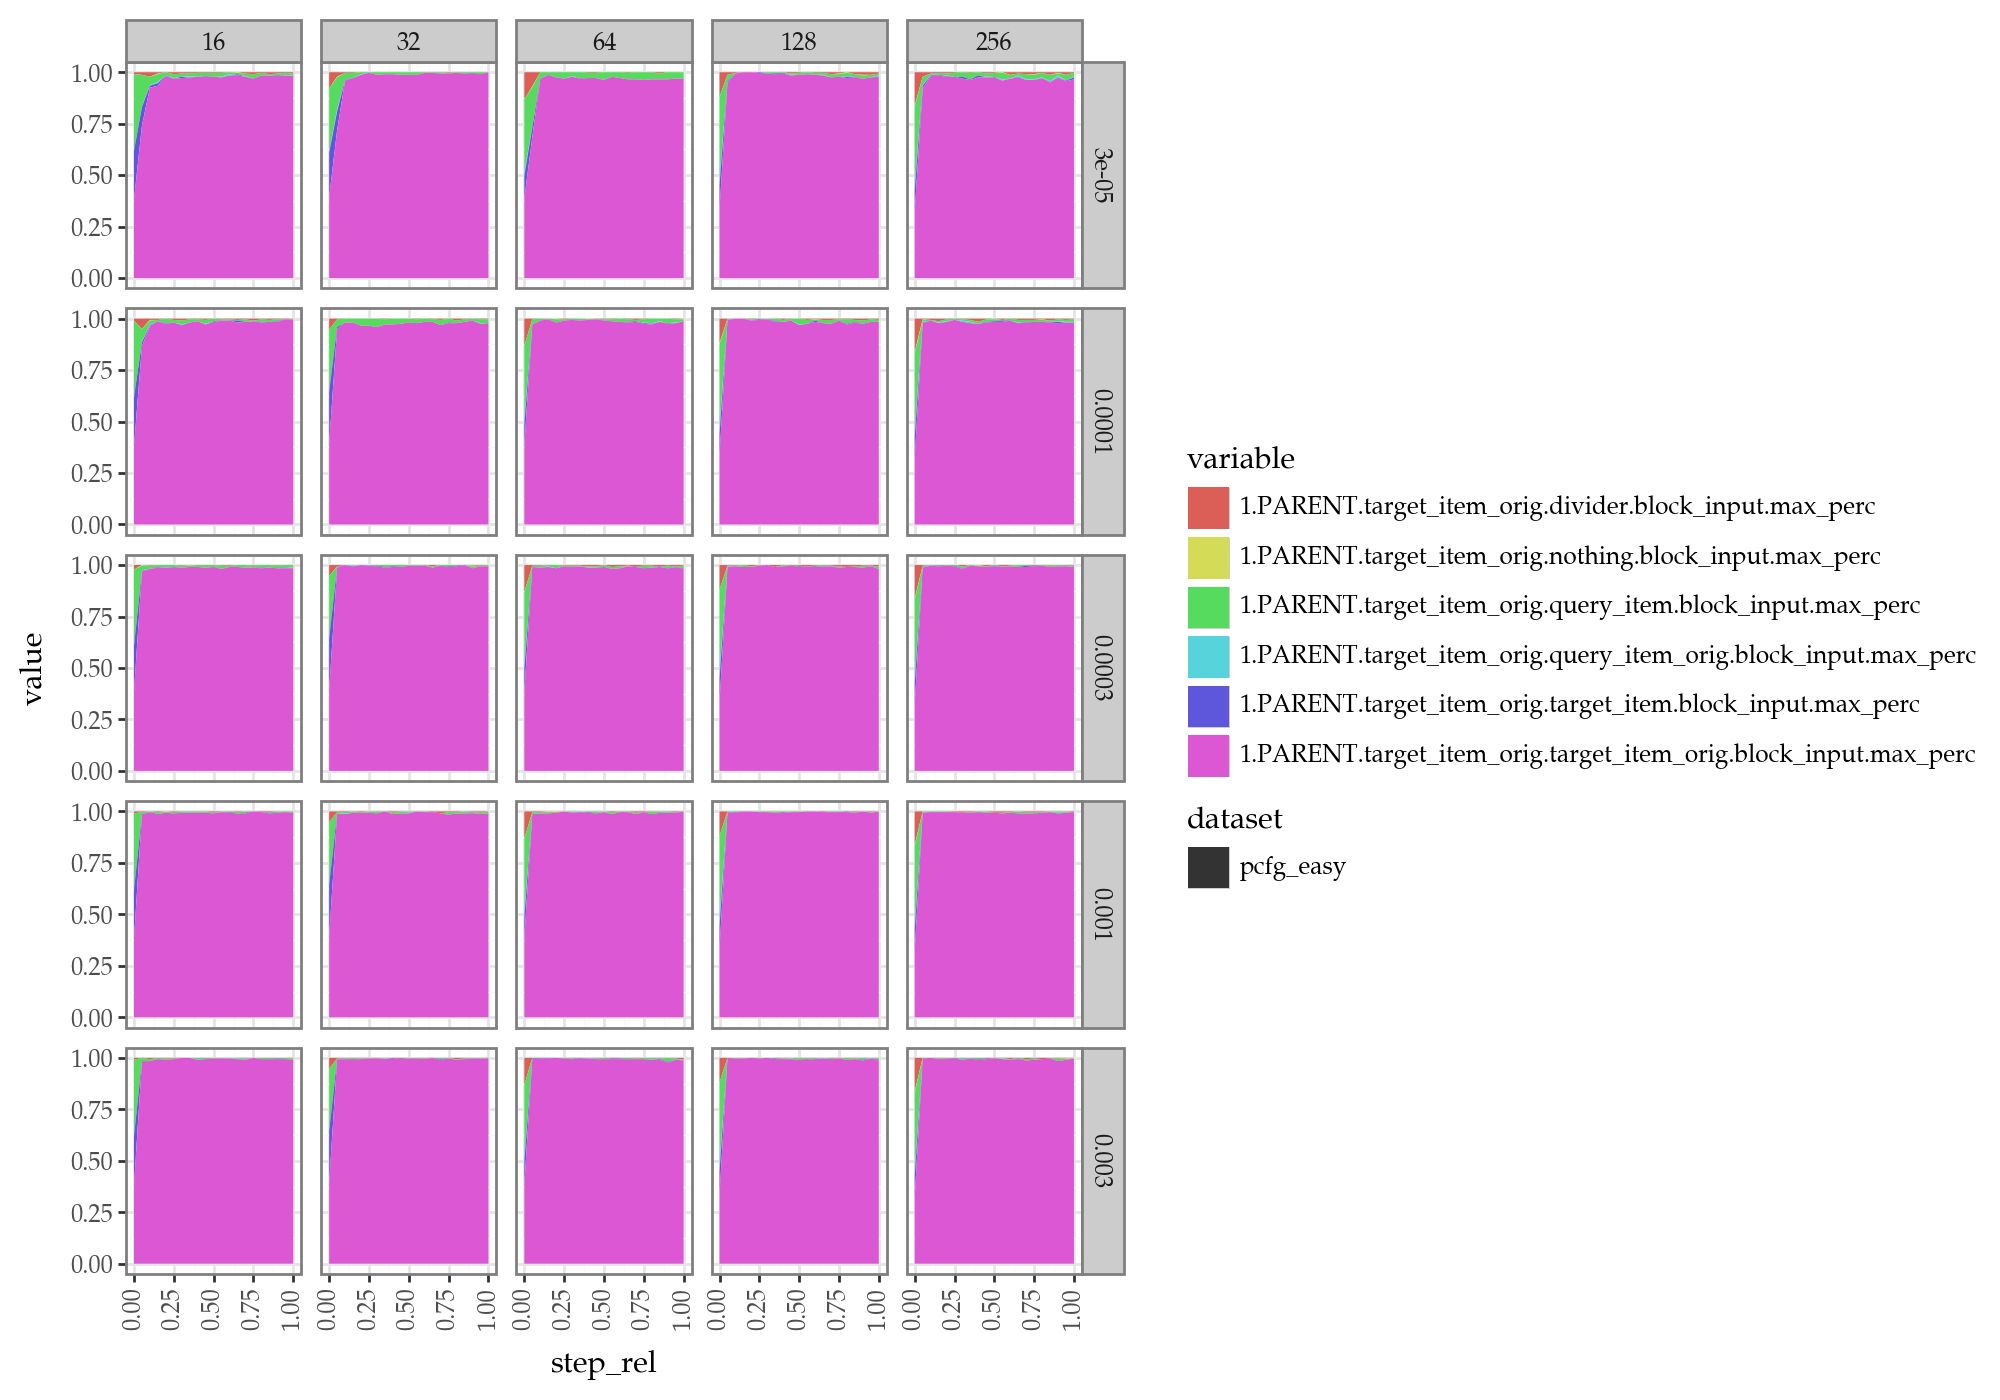

In [48]:
subset_df = df_int[
    (df_int["variable"].str.contains(r"1\.PARENT\.target_item_orig\..*?\.block_input\.max_perc$", regex=True)) &
    (df_int["arch"] == "H3") & 
    (df_int["dataset"] == "pcfg_easy")
]
plot = (
    p9.ggplot(subset_df, p9.aes(x="step_rel", y="value", fill="variable", linetype="dataset", group="variable")) +
    p9.geom_area(position="stack") +
    # p9.geom_point() +
    # p9.geom_point() +
    p9.facet_grid("lr~dim") +
    # p9.scale_x_log10() +
    p9.theme(figure_size=(10, 7))
)
plot.show()

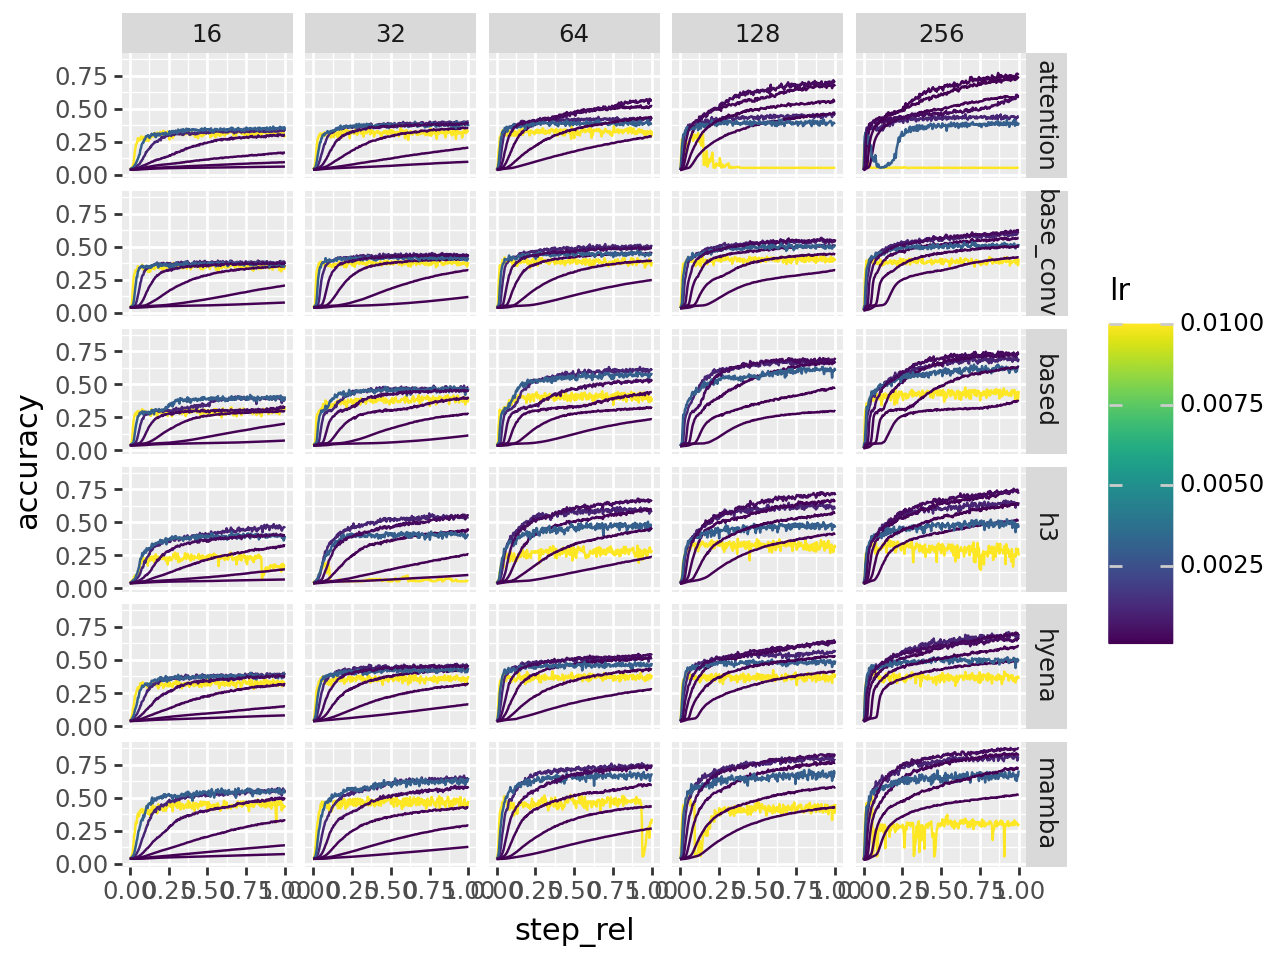

In [8]:
subset_df = df[df["variable"] == "query_item.pred_prob"]
plot = (
    p9.ggplot(subset_df, p9.aes(x="step_rel", y="value", color="lr", group="identifier")) +
    p9.geom_line() +
    p9.facet_grid("arch~dim") +
    p9.scale_x_log10() +
    # p9.scale_color_gradient(low="blue", high="red") +
    p9.labs(y="accuracy")
)
plot.show()

/juice2/scr2/aryaman/tinylang/.venv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10


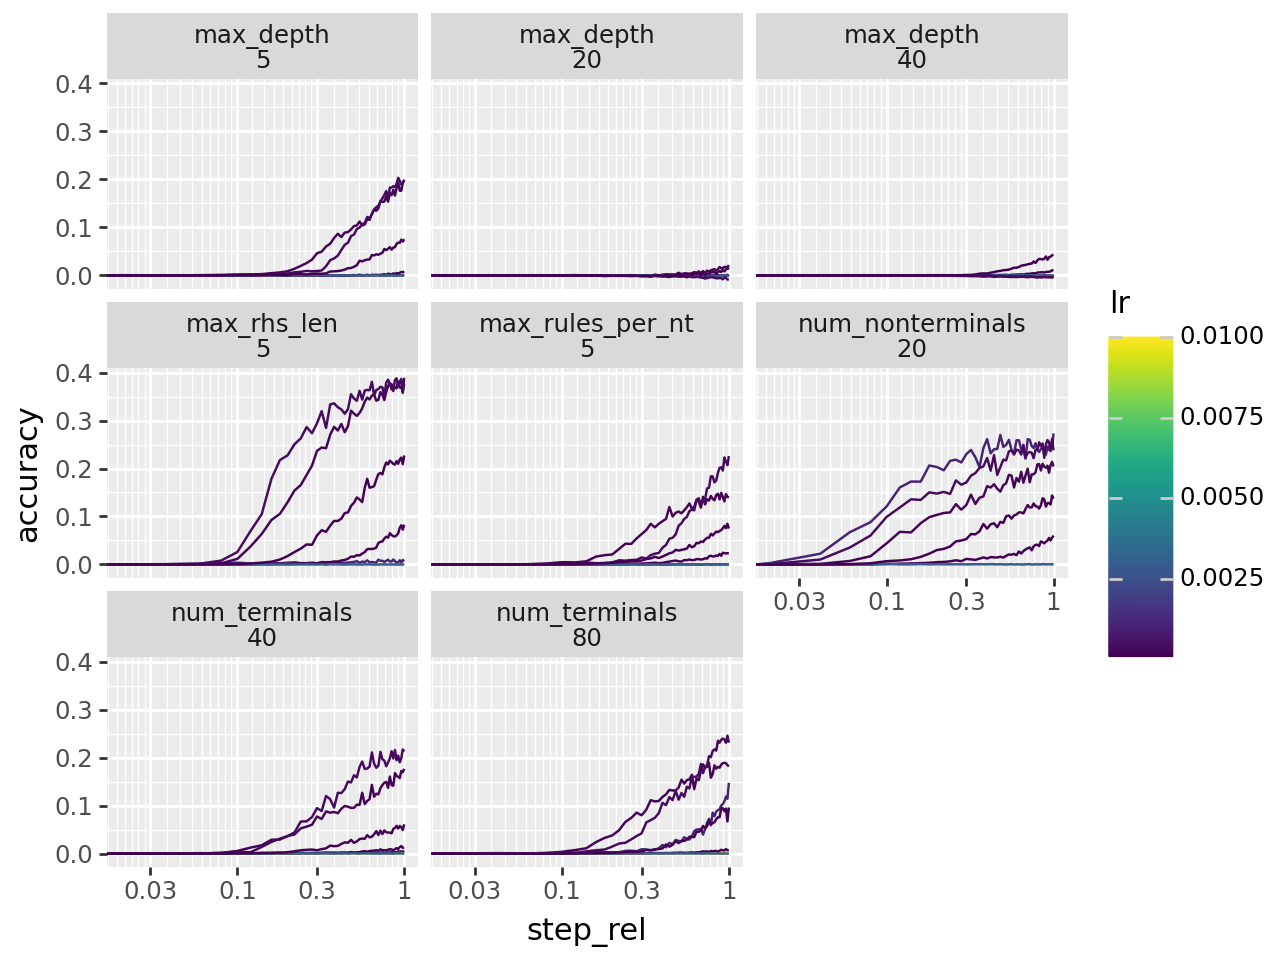

In [31]:
# eval/InterchangeEvaluator/1.PARENT.query_item_orig.target_item_orig.block_input.prob_diff and model.config.n_embd v. eval/SummaryEvaluator/query_item.pred_prob
subset_df = df[df["variable"] == "1.PARENT.query_item_orig.target_item_orig.block_input.prob_diff"]
plot = (
    p9.ggplot(subset_df, p9.aes(x="step_rel", y="value", color="lr", group="identifier")) +
    p9.geom_line() +
    p9.facet_wrap("~ablation + ablation_val") +
    p9.scale_x_log10() +
    # p9.scale_color_gradient(low="blue", high="red") +
    p9.labs(y="accuracy")
)
plot.show()

['step_rel', 'lr', 'ablation', 'ablation_val', '1.PARENT.query_item_orig.target_item_orig.block_input.prob_diff', 'query_item.pred_prob', 'identifier']
2856


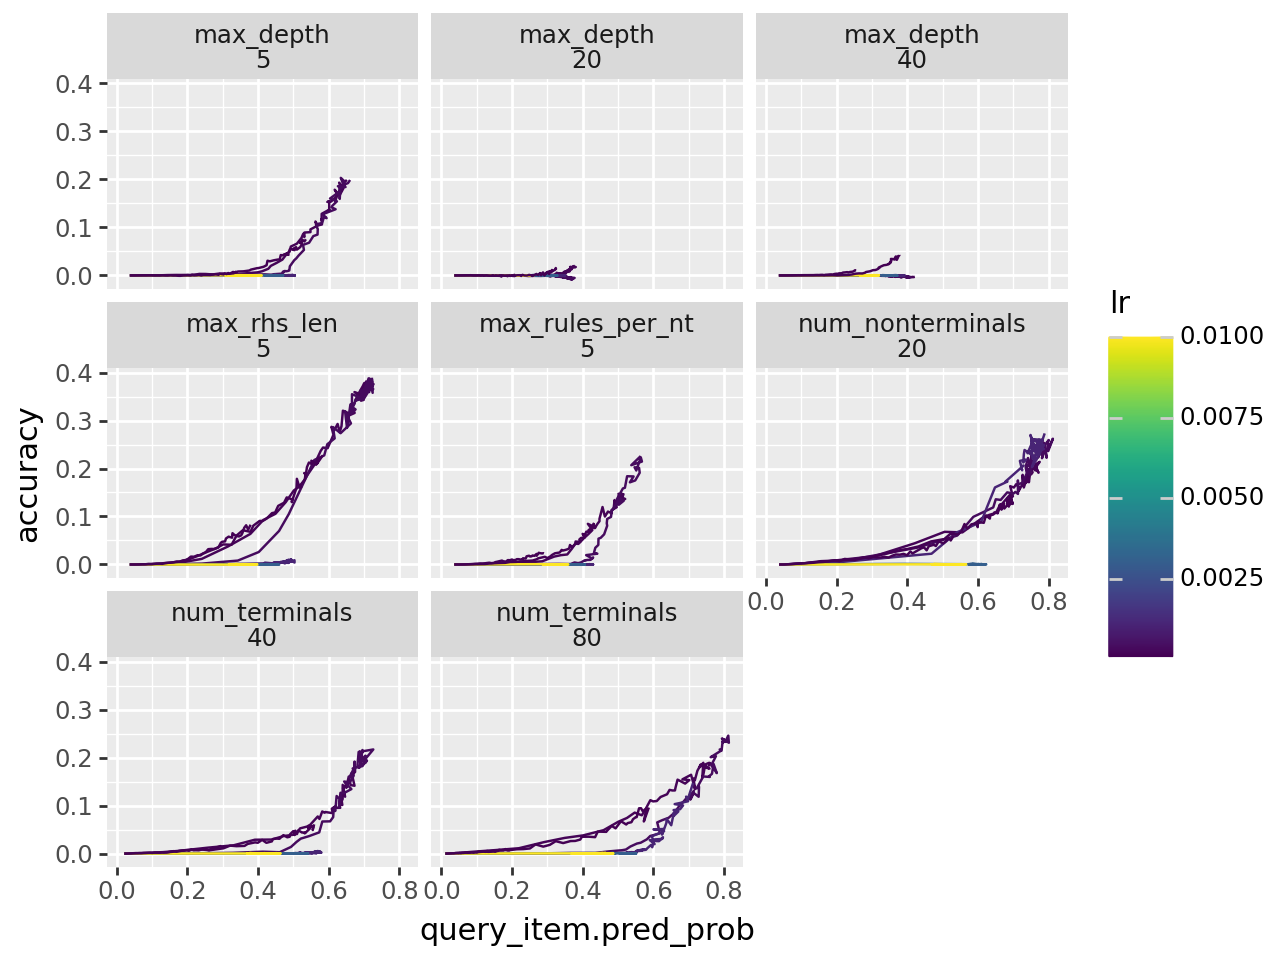

In [79]:
# eval/InterchangeEvaluator/1.PARENT.query_item_orig.target_item_orig.block_input.prob_diff and model.config.n_embd v. eval/SummaryEvaluator/query_item.pred_prob
subset_df = df[df["variable"].isin(["1.PARENT.query_item_orig.target_item_orig.block_input.prob_diff", "query_item.pred_prob"])]
subset_df = subset_df.pivot(index=["step_rel", "lr", "ablation", "ablation_val"], columns="variable", values="value").reset_index()
subset_df["identifier"] = subset_df["lr"].apply(lambda x: str(x))
# subset_df["lr"] = subset_df["lr"].astype(str)
subset_df = subset_df.sort_values(by=["identifier", "step_rel"]).dropna()
# print(subset_df.head())
print(list(subset_df.columns))
print(len(subset_df))
# print(subset_df)
plot = (
    p9.ggplot(subset_df, p9.aes(x="query_item.pred_prob", y="1.PARENT.query_item_orig.target_item_orig.block_input.prob_diff", color="lr", group="identifier")) +
    p9.geom_path() +
    p9.facet_wrap("~ablation + ablation_val") +
    # p9.scale_x_log10() +
    # p9.scale_color_gradient(low="blue", high="red") +
    p9.labs(y="accuracy")
)
plot.show()


['step_rel', 'lr', 'ablation', 'ablation_val', '0.PARENT.target_item_orig.target_item_orig.attention_input.logit_diff', '1.PARENT.query_item_orig.target_item_orig.attention_input.logit_diff', 'identifier']
2856


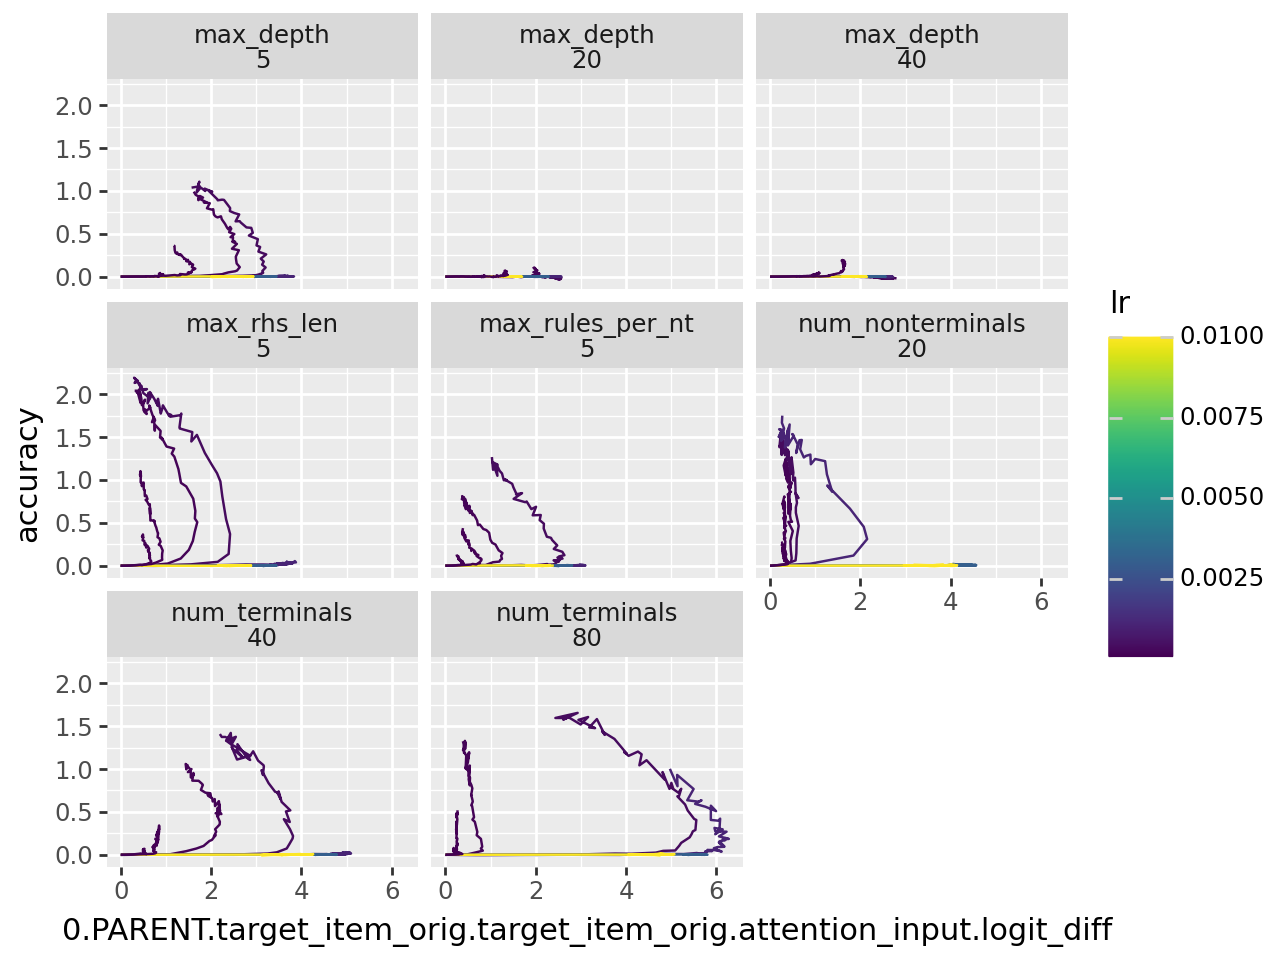

In [112]:
# eval/InterchangeEvaluator/1.PARENT.query_item_orig.target_item_orig.block_input.prob_diff and model.config.n_embd v. eval/SummaryEvaluator/query_item.pred_prob
subset_df = df[df["variable"].isin(["1.PARENT.query_item_orig.target_item_orig.attention_input.logit_diff", "0.PARENT.target_item_orig.target_item_orig.attention_input.logit_diff"])]
subset_df = subset_df.pivot(index=["step_rel", "lr", "ablation", "ablation_val"], columns="variable", values="value").reset_index()
subset_df["identifier"] = subset_df["lr"].apply(lambda x: str(x))
# subset_df["lr"] = subset_df["lr"].astype(str)
subset_df = subset_df.sort_values(by=["identifier", "step_rel"]).dropna()
# print(subset_df.head())
print(list(subset_df.columns))
print(len(subset_df))
# print(subset_df)
plot = (
    p9.ggplot(subset_df, p9.aes(x="0.PARENT.target_item_orig.target_item_orig.attention_input.logit_diff", y="1.PARENT.query_item_orig.target_item_orig.attention_input.logit_diff", color="lr", group="identifier")) +
    p9.geom_path() +
    p9.facet_wrap("~ablation + ablation_val") +
    # p9.scale_x_log10() +
    # p9.scale_color_gradient(low="blue", high="red") +
    p9.labs(y="accuracy")
)
plot.show()


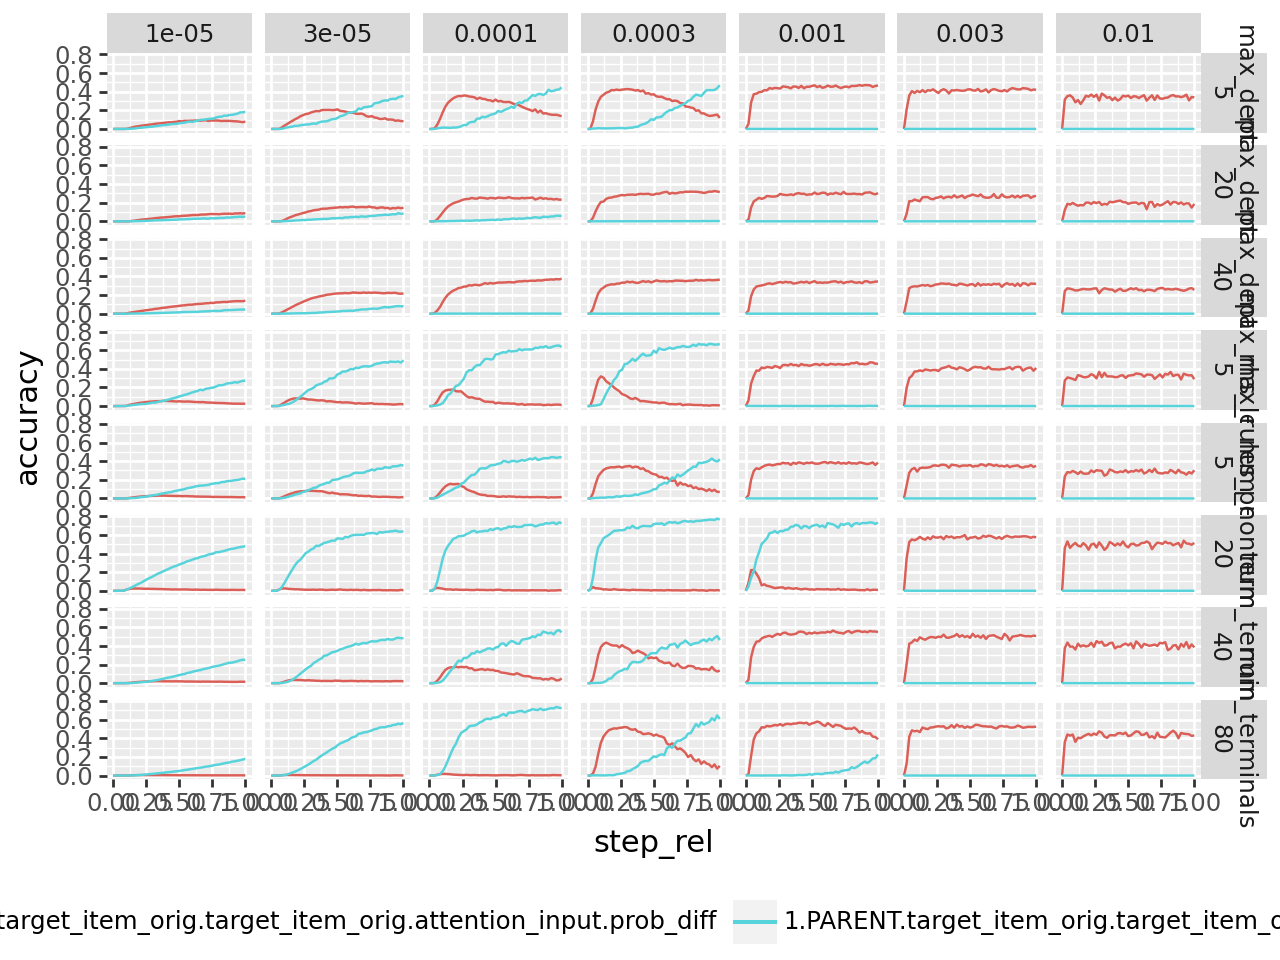

In [110]:
# eval/InterchangeEvaluator/1.PARENT.query_item_orig.target_item_orig.block_input.prob_diff and model.config.n_embd v. eval/SummaryEvaluator/query_item.pred_prob
subset_df = df[df["variable"].isin([
    "0.PARENT.target_item_orig.target_item_orig.attention_input.prob_diff",
    "1.PARENT.target_item_orig.target_item_orig.attention_input.prob_diff"
])]
plot = (
    p9.ggplot(subset_df, p9.aes(x="step_rel", y="value", color="variable", group="variable")) +
    p9.geom_line() +
    p9.facet_grid("ablation + ablation_val~lr") +
    # p9.scale_x_log10() +
    # p9.scale_color_gradient(low="blue", high="red") +
    p9.labs(y="accuracy") +
    p9.theme(legend_position="bottom")
)
plot.show()

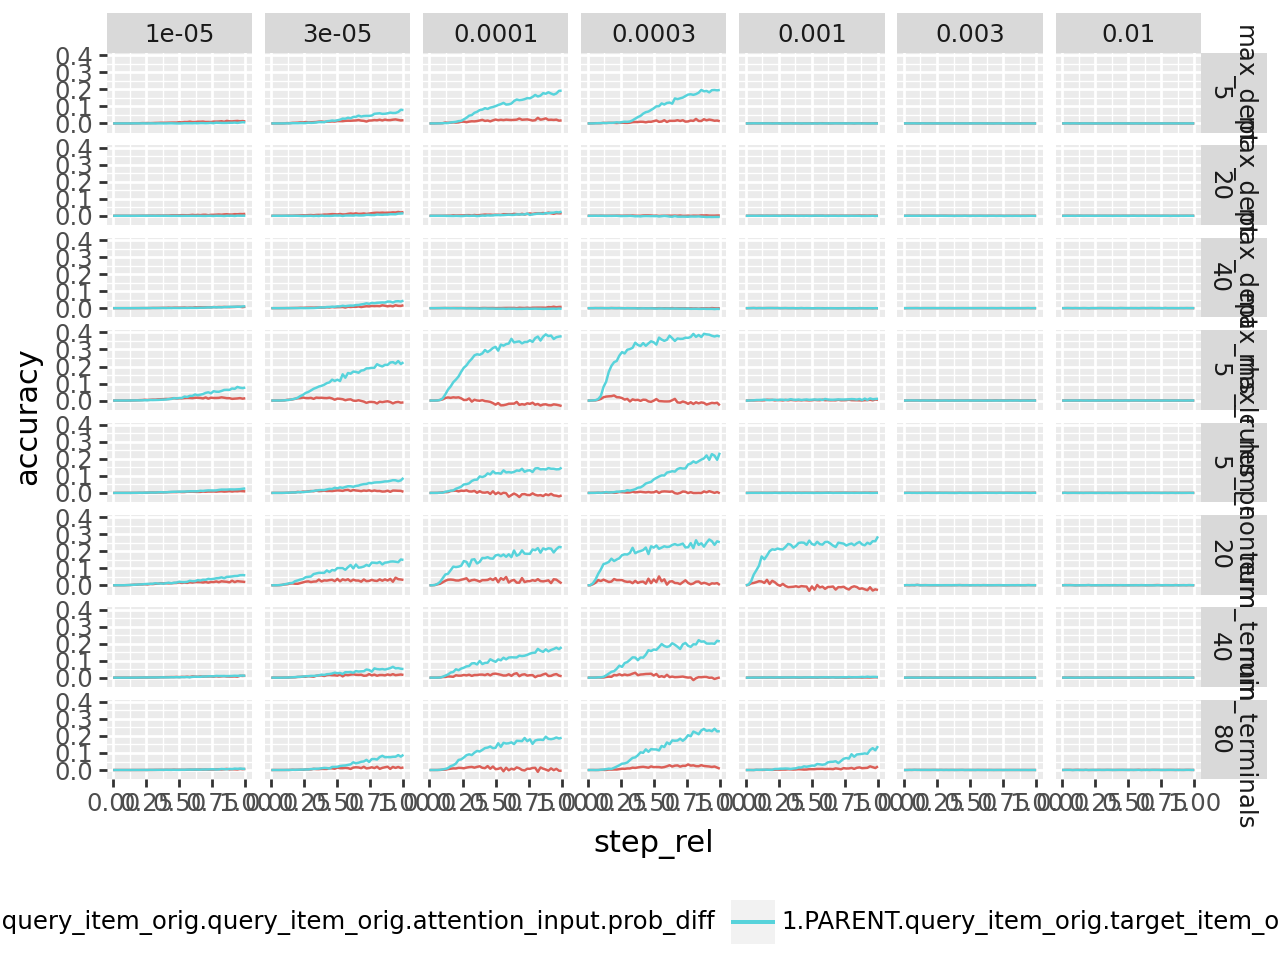

In [106]:
# eval/InterchangeEvaluator/1.PARENT.query_item_orig.target_item_orig.block_input.prob_diff and model.config.n_embd v. eval/SummaryEvaluator/query_item.pred_prob
subset_df = df[df["variable"].isin([
    "1.PARENT.query_item_orig.query_item_orig.attention_input.prob_diff",
    "1.PARENT.query_item_orig.target_item_orig.attention_input.prob_diff"
])]
plot = (
    p9.ggplot(subset_df, p9.aes(x="step_rel", y="value", color="variable", group="variable")) +
    p9.geom_line() +
    p9.facet_grid("ablation + ablation_val~lr") +
    # p9.scale_x_log10() +
    # p9.scale_color_gradient(low="blue", high="red") +
    p9.labs(y="accuracy") +
    p9.theme(legend_position="bottom")
)
plot.show()